# Produce plots from UM year output for LMD comparison - Danny GMD

#### Sections:
0. Select target month
1. Import libraries
2. Load in UM data
3. Load in LMD data
4. Define months
5. Global parameters
    1. Dust
    2. Winds
    3. Temperature
    4. Pressure

In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
selected_month = input('Please select the target month as a 2-digit value (e.g. "01"), needed for LMD data extraction: ')
selected_month_int = int(selected_month)

Please select the target month as a 2-digit value (e.g. "01"), needed for LMD data extraction:  05


#### Import libraries

In [3]:
from pathlib import Path
from scipy import misc
import iris
import iris.plot as iplt
import iris.quickplot as qplt
from iris.experimental import stratify
from iris.coord_categorisation import add_categorised_coord
import iris.common.resolve
import iris.util
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcol
import matplotlib.patheffects as PathEffects
from aeolus.calc import time_mean as t_m 
from aeolus.calc import spatial_mean as s_m
from aeolus.calc import zonal_mean as z_m
from aeolus.calc import vertical_mean as v_m
from aeolus.calc import meridional_mean as m_m
from aeolus.coord import isel, regrid_3d, get_cube_rel_days, get_xy_coords, interp_to_cube_time, add_planet_calendar,roll_cube_pm180
from aeolus.plot.pv import grid_for_scalar_cube_sph, grid_for_vector_cubes_sph
from aeolus.plot import GeoAxesGrid, label_global_map_gridlines
from aeolus.subset import CM_INST_CONSTR, CM_MEAN_CONSTR, extract_last_n_days, l_range_constr
from aeolus.model.base import Model
from aeolus.model import um
import datetime 
import time
import cf_units
import pyvista as pv
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy as np
from tqdm.notebook import tqdm
from functools import partial
from scipy import interpolate
import math

pv.set_plot_theme('document')

import warnings
#Select if you want warnings or not
# warnings.filterwarnings('default')
warnings.filterwarnings('ignore')


plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
start_time = time.time()
loaded=False #define wether the data has been read in yet, purpose is to avoid accidently running the cell that loads in the data 1<

#### Load in UM data

In [4]:
save = False
scenario = '7.5_dust'
save_dir = f'/data/dm575/GMD/plots/{scenario}/'
year_analysis = False #Do you want the year dust distributions? Only matters at the end of the notebook

In [7]:
%%time
path = f'/data/dm575/GMD/UM/{scenario}/year_2/umglaa.p'
pa= iris.load(f'{path}a*')
print('pa done')
pb= iris.load(f'{path}b*')
print('pb done')
pc= iris.load(f'{path}c*')
print('pc done')
pd= iris.load(f'{path}d*')
print('pd done')
pe= iris.load(f'{path}e*') # air temp + toa sw in and out
print('pe done')
pf= iris.load(f'{path}f*') # winds 
print('pf done')
pg= iris.load(f'{path}g*') # air_pres, temps, toa lw out
print('pg done')
ph= iris.load(f'{path}h*') # surface sw
print('ph done')
pi= iris.load(f'{path}i*') # dust
print('pi done')
p=[pa,pb,pc,pd,pe,pf,pg,ph,pi]

pa done
pb done
pc done
pd done
pe done
pf done
pg done
ph done
pi done
CPU times: user 30min 28s, sys: 17.2 s, total: 30min 45s
Wall time: 30min 45s


In [8]:
pi

Mass Fraction Of Dust Ukmo Division 1 Dry Aerosol In Air (kg/kg),time,model_level_number,latitude,longitude
Shape,670,51,90,144
Dimension coordinates,,,,
time,x,-,-,-
model_level_number,-,x,-,-
latitude,-,-,x,-
longitude,-,-,-,x
Auxiliary coordinates,,,,
forecast_period,x,-,-,-
forecast_reference_time,x,-,-,-
level_height,-,x,-,-


In [9]:
# Print out what variables are in which object, mainly used if you've not got too much memory and need to chunk-load only certain parameters
char=['a','b','c','d','e','f','g','h','i']
for i in range(0,9): #Only from 'pe' onwards does Sol output start, the rest is Earth day output
    try:
        print(f'p{char[i]}:')
        print(p[i])
    except:
        print('no pa')

pa:
0: mass_fraction_of_dust_ukmo_division_4_dry_aerosol_in_air / (kg/kg) (time: 23; model_level_number: 51; latitude: 90; longitude: 144)
1: mass_fraction_of_dust_ukmo_division_1_dry_aerosol_in_air / (kg/kg) (time: 4; model_level_number: 51; latitude: 90; longitude: 144)
2: mass_fraction_of_dust_ukmo_division_2_dry_aerosol_in_air / (kg/kg) (time: 4; model_level_number: 51; latitude: 90; longitude: 144)
3: mass_fraction_of_dust_ukmo_division_3_dry_aerosol_in_air / (kg/kg) (time: 4; model_level_number: 51; latitude: 90; longitude: 144)
4: mass_fraction_of_dust_ukmo_division_4_dry_aerosol_in_air / (kg/kg) (time: 4; model_level_number: 51; latitude: 90; longitude: 144)
5: mass_fraction_of_dust_ukmo_division_5_dry_aerosol_in_air / (kg/kg) (time: 4; model_level_number: 51; latitude: 90; longitude: 144)
6: mass_fraction_of_dust_ukmo_division_6_dry_aerosol_in_air / (kg/kg) (time: 4; model_level_number: 51; latitude: 90; longitude: 144)
7: air_potential_temperature / (K)     (time: 4; model_le

In [10]:
dust_3 = pi.extract(CM_MEAN_CONSTR).extract_cube("mass_fraction_of_dust_ukmo_division_3_dry_aerosol_in_air")
dust_4 = pi.extract(CM_MEAN_CONSTR).extract_cube("mass_fraction_of_dust_ukmo_division_4_dry_aerosol_in_air")
dust_5 = pi.extract(CM_MEAN_CONSTR).extract_cube("mass_fraction_of_dust_ukmo_division_5_dry_aerosol_in_air")
dust_1 = pi.extract(CM_MEAN_CONSTR).extract_cube("mass_fraction_of_dust_ukmo_division_1_dry_aerosol_in_air")
dust_2 = pi.extract(CM_MEAN_CONSTR).extract_cube("mass_fraction_of_dust_ukmo_division_2_dry_aerosol_in_air")
dust_6 = pi.extract(CM_MEAN_CONSTR).extract_cube("mass_fraction_of_dust_ukmo_division_6_dry_aerosol_in_air")
UM_dust_pre=dust_3+dust_4+dust_5+dust_1+dust_2+dust_6
UM_dust_pre.rename('dust_mmr')

del dust_1
del dust_2
del dust_3
del dust_4
del dust_5
del dust_6


In [11]:
UM_pres_pre     = pg.extract(CM_MEAN_CONSTR).extract_cube('air_pressure')
UM_surfpres_pre = pg.extract(CM_MEAN_CONSTR).extract_cube('surface_air_pressure')
UM_surftemp_pre = pg.extract(CM_MEAN_CONSTR).extract_cube("surface_temperature")
UM_temp_pre     = pg.extract(CM_MEAN_CONSTR).extract_cube("air_temperature")
UM_xwind_pre    = pf.extract(CM_MEAN_CONSTR).extract_cube("x_wind")
UM_ywind_pre    = pf.extract(CM_MEAN_CONSTR).extract_cube("y_wind")
%time UM_ywind_pre    = regrid_3d(UM_ywind_pre,UM_xwind_pre) # remove the extra latitude value
UM_zwind_pre    = pf.extract(CM_MEAN_CONSTR).extract_cube("upward_air_velocity")
%time UM_zwind_pre    = regrid_3d(UM_zwind_pre,UM_xwind_pre) #remove the extra vertical level

CPU times: user 48 ms, sys: 8 ms, total: 56 ms
Wall time: 54.3 ms
CPU times: user 3min 51s, sys: 48.8 s, total: 4min 39s
Wall time: 2min 8s


In [12]:
sigma_lev = 0.01
sigma_0_difference = (1-sigma_lev)/100

step_sig = np.linspace(1,sigma_lev,100)

In [13]:
len(step_sig)

100

##### Convert to sigma height

In [14]:
INTERPOLATOR = partial(
    stratify.stratify.interpolate,
    interpolation=stratify.stratify.INTERPOLATE_LINEAR,
    extrapolation=stratify.stratify.EXTRAPOLATE_LINEAR,
)

/home/dm575


### Run from here

In [15]:
def broadcast_cube(src_cube, target_cube, **kwargs):
    """Broadcast cube to the shape of another cube with at least 1 matching dimension."""
    mapping = src_cube.metadata._asdict()
    mapping.update(**kwargs)
    resolver = iris.common.resolve.Resolve(src_cube, target_cube)
    dim_map = [target_cube.coord_dims(coord)[0] for coord in src_cube.dim_coords]
    try:
        data_bcast = iris.util.broadcast_to_shape(src_cube.core_data(), target_cube.shape, dim_map)
    except AttributeError:
        data_bcast = iris.util.broadcast_to_shape(src_cube.data, target_cube.shape, dim_map)
    result = resolver.cube(data_bcast)
    result.metadata = mapping
    return result

#### Load in LMD data

In [16]:
lmd = Model(
    # Coordinates
    t="Time",
    z="altitude",
    lev="level_height",
    y="latitude",
    x="longitude",
    # Variables
    u="u",
    v="v",
    w="w",
    pres="p",
)
Sigma_P = Model(
    # Coordinates
    t="Time",
    z="sigma_p",
    lev="sigma_p",
    y="latitude",
    x="longitude",
    # Variables
    u="u",
    v="v",
    w="w",
    pres="p",
)

In [17]:
%%time

'''
The following code extracts the different variables from the LMD dataset. It then regrids the time to a format compatible with the Aeolus package (used for the UM), 
this doesn't actually affect the time, as the time is just "days since start" anyway, which is the same point for the UM and LMD.

In this comparison we're not looking at diurnal cycles, so the monthly data (which is split into 12 sections of 2-hour means of that time, 
e.g. time[1] will have the means of everything between 2-4am across the month) is meaned so that each month is one mean of all values across that month (so no 'Time' dimension)

Variables have the name format of "LMD_variable" for consistancy.
'''

LMD_path = '/data/dm575/GMD/LMD/clim_aveEUV/clim_'

LMD = iris.load(f'{LMD_path}{selected_month}_me.nc')
# print(LMD) #prints all the variables and their names if needed

## Dust mass mixing ratio ##
LMD_dust = LMD.extract_cube('dustq')
LMD_dust.coord("Time").units = cf_units.Unit("hours since 2044-11-15")
LMD_dust = t_m(LMD_dust,model=lmd) # Mean all the hours of the dataset

## Dust effective radius ## 
LMD_dustradius = LMD.extract_cube('reffdust')
LMD_dustradius.coord("Time").units = cf_units.Unit("hours since 2044-11-15")
LMD_dustradius = t_m(LMD_dustradius,model=lmd) # Mean all the hours of the dataset

## Winds ##
LMD_xwind = LMD.extract_cube('u')
LMD_xwind.coord("Time").units = cf_units.Unit("hours since 2044-11-15")
LMD_xwind = t_m(LMD_xwind,model=lmd) # Mean all the hours of the dataset

LMD_ywind = LMD.extract_cube('v')
LMD_ywind.coord("Time").units = cf_units.Unit("hours since 2044-11-15")
LMD_ywind = t_m(LMD_ywind,model=lmd) # Mean all the hours of the dataset

LMD_zwind = LMD.extract_cube('w')
LMD_zwind.coord("Time").units = cf_units.Unit("hours since 2044-11-15")
LMD_zwind = t_m(LMD_zwind,model=lmd) # Mean all the hours of the dataset

## Temperatures
LMD_temp = LMD.extract_cube('temp')
LMD_temp.coord("Time").units = cf_units.Unit("hours since 2044-11-15")
LMD_temp = t_m(LMD_temp,model=lmd) # Mean all the hours of the dataset

LMD_surftemp = LMD.extract_cube('tsurf')
LMD_surftemp.coord("Time").units = cf_units.Unit("hours since 2044-11-15") 
LMD_surftemp = t_m(LMD_surftemp,model=lmd) # Mean all the hours of the dataset

## Pressure ## 
LMD_surfpres = LMD.extract_cube('ps')
LMD_surfpres.coord("Time").units = cf_units.Unit("hours since 2044-11-15") 
LMD_surfpres = t_m(LMD_surfpres,model=lmd) # Mean all the hours of the dataset

## Shortwave flux ## 
LMD_sw = LMD.extract_cube('fluxsurf_sw')
LMD_sw.coord("Time").units = cf_units.Unit("hours since 2044-11-15") 
LMD_sw = t_m(LMD_sw,model=lmd) # Mean all the hours of the dataset

# Pressure fields
LMD_aps = LMD.extract_cube('aps')
LMD_bps = LMD.extract_cube('bps')
LMD_ps  = LMD.extract_cube('ps')
LMD_ps.coord("Time").units = cf_units.Unit("hours since 2044-11-15") 

LMD_pres = broadcast_cube(LMD_aps,LMD_dust) + broadcast_cube(LMD_bps,LMD_dust)*broadcast_cube(t_m(LMD_ps,model=lmd),LMD_dust)
LMD_pres.rename('pressure')


CPU times: user 488 ms, sys: 16 ms, total: 504 ms
Wall time: 794 ms


In [18]:



def calc_virtual_temp_lmdg(lmdg_cl, epsilon=188.92 / 461.52):
    r"""
    Calculate virtual temperature from LMD-G data.

    .. math::
        T_v = T \frac{(1 + R_v / \epsilon)}{1 + R_v}

    Parameters
    ----------
    lmdg_cl: iris.cube.CubeList
        Model dataset with the required variables: "vmr_h2ovapor" and "temp".
    epsilon: float, optional
        Ratio of dry air and condensible species gas constants.
        By default, uses values for the Mars dry air, 188.92 [J kg-1 K-1],
        divided by water, 461.52 [J kg-1 K-1].

    Returns
    -------
    iris.cube.Cube
        Cube of virtual temperature.
    """
    # Extract real temperature
    temp = lmdg_cl.extract_cube("temp")
    # Extract volume mixing ratio of water
    vmr_h2o = lmdg_cl.extract_cube("vmr_h2ovapor")
    # Calculate virtual temperature
    temp_v = temp * (1 + vmr_h2o / epsilon) / (1 + vmr_h2o)
    return temp_v


def calc_alt_lmdg(
    lmdg_cl,
    dry_air_gas_constant=iris.cube.Cube(188.92, units="J kg-1 K-1"),
    condens_gas_constant=iris.cube.Cube(461.52, units="J kg-1 K-1"),
    gravity=iris.cube.Cube(3.7257964, units="m s-2"),
):
    r"""
    Derive a 3D array of altitude for LMD-G using the hypsometric equation.

    .. math::
        h = \frac{R T_v}{g} ln{ \frac{p_1}{p_2} }

    Parameters
    ----------
    lmdg_cl: iris.cube.CubeList
        LMD-G dataset with the required variables:
        "temp", "vmr_h2ovapor", "aps", "bps", "ap", "bp", "ps".
    dry_air_gas_constant: iris.cube.Cube, optional
        Dry air gas constant [J kg-1 K-1].
    condens_gas_constant: iris.cube.Cube, optional
        Condensible species gas constant, such as 461.52 [J kg-1 K-1] for water.
    gravity: iris.cube.Cube, optional
        Gravity constant [m s-2]. By default, the value for Mars is used.

    Returns
    -------
    lev_alt: iris.cube.Cube
        Array of altitude level [m].
    """
    # Calculate virtual temperature
    temp_v = calc_virtual_temp_lmdg(lmdg_cl, epsilon=dry_air_gas_constant / condens_gas_constant)
    # Calculate pressure at midlayers
    ps = lmdg_cl.extract_cube("ps")
    pres_m = broadcast_cube(lmdg_cl.extract_cube("aps"), temp_v, units="Pa") + broadcast_cube(
        lmdg_cl.extract_cube("bps"), temp_v, units="1"
    ) * broadcast_cube(ps, temp_v)
    pres_m.rename("air_pressure")
    # Calculate the geopotential height thickness
    log_p_over_ps = iris.analysis.maths.apply_ufunc(
        np.log, ps / pres_m, new_name="log_of_air_pressure_over_surface_pressure", new_unit="1"
    )
    lev_alt = (dry_air_gas_constant * temp_v / gravity) * log_p_over_ps
    lev_alt.rename("altitude")
    lev_alt.attributes["title"] = "Altitude at midlayers"
    return lev_alt

def get_data_max_min(UM_data,LMD_data,contour=True,dust=False,flat=False):
    r'''
    Extract the maximum and minimum values between two cubes
    
    Parameters
    ----------
    UM_data: iris.cube.Cube
        First dataset, doesn't need to be UM
    LMD_data: iris.cube.Cube
        First dataset, doesn't need to be LMD
    contour: boolean, optional
        Centres the white around 0 for the step counter, only needed in contour plots
    dust: boolean, optional
        Stops the rounding of the values, to be used for small datasets (e.g. the dust parameters)
    flat: boolean, optional
        If True; uses sigma_p coordinates also, if False; just does lat & lon
    
    Returns
    -------
    y_max: Maximum value between the two datasets, rounded up
    y_min: Minimum value between the two datasets, rounded down
    y_step: Steps between the two max/min values, to the nearest 10 (or 1 for smaller values)
    '''
    if flat ==False:
        UM_max_data = UM_data.collapsed(["latitude","longitude",'sigma_p'], iris.analysis.MAX).data
        UM_min_data = UM_data.collapsed(["latitude","longitude",'sigma_p'], iris.analysis.MIN).data

        LMD_max_data = LMD_data.collapsed(["latitude","longitude",'sigma_p'], iris.analysis.MAX).data
        LMD_min_data = LMD_data.collapsed(["latitude","longitude",'sigma_p'], iris.analysis.MIN).data
        print(f'UM max {UM_max_data}')
        print(f'UM min {UM_min_data}')
        print(f'LMD max {LMD_max_data}')
        print(f'LMD min {LMD_min_data}')
    #In case its a 2-D cube
    else: 
        UM_max_data = UM_data.collapsed(["latitude","longitude"], iris.analysis.MAX).data
        UM_min_data = UM_data.collapsed(["latitude","longitude"], iris.analysis.MIN).data

        LMD_max_data = LMD_data.collapsed(["latitude","longitude"], iris.analysis.MAX).data
        LMD_min_data = LMD_data.collapsed(["latitude","longitude"], iris.analysis.MIN).data
    
    if dust ==True:
        if UM_max_data >= LMD_max_data:
            y_max = UM_max_data
        else:
            y_max = LMD_max_data
        if LMD_min_data >= UM_min_data:
            y_min = UM_min_data
        else:
            y_min = LMD_min_data
    else:
        if UM_max_data >= LMD_max_data:
            y_max = math.ceil(UM_max_data/10)*10
        else:
            y_max = math.ceil(LMD_max_data/10)*10
        if LMD_min_data >= UM_min_data:
            y_min = math.floor(UM_min_data/10)*10
        else:
            y_min = math.floor(LMD_min_data/10)*10
    if contour==True:
        if y_max >= math.sqrt((y_min)**2):
            y_min = y_max-(y_max*2)
        else:
            y_max = y_min-(y_min*2)
    y_step = (round(((y_max-y_min)/20)/10))*10 
    if y_step==0:
        y_step =(y_max-y_min)/20
    return y_max,y_min,y_step


In [19]:
LMD = iris.load(f'{LMD_path}{selected_month}_me.nc')

alt_4d= calc_alt_lmdg(LMD)
alt_4d = t_m(alt_4d,model=lmd)
alt_4d.coord("Time").units = cf_units.Unit("hours since 2044-11-15")


In [20]:
# UM_alt_4d = calc_alt_lmdg(pg)

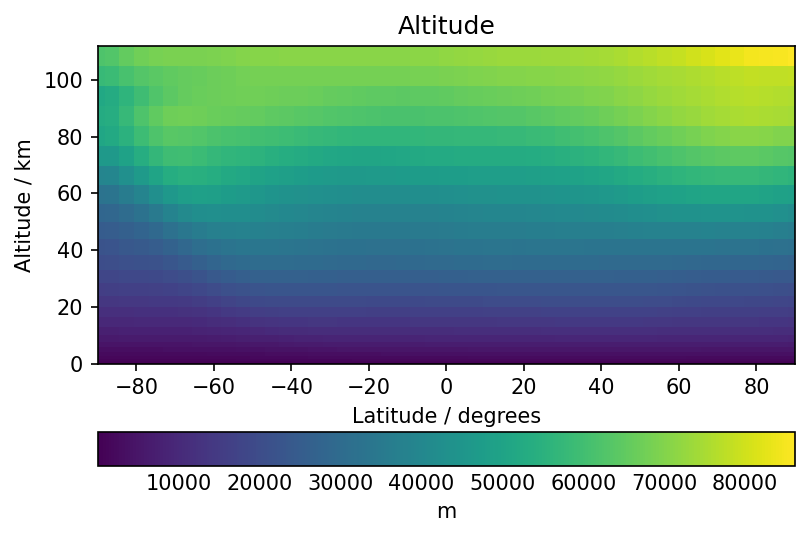

In [21]:
qplt.pcolormesh(z_m(alt_4d,model=lmd))

#### Define months

In [22]:
'''
Months in the LMD are interpreted as sections of 30 degrees solar longitude, which because of Mars' orbit eccentricity, causes the months to have different lengths.
The month length can be found below.

A cumulative month count is used for extracting the correct dates from the UM, which is configured to output every 24 hours and 40 minutes.

Month number | Solar longitude range | Sols in that month:
1 | 0 - 30    | 61
2 | 30 - 60   | 66
3 | 60 - 90   | 66
4 | 90 - 120  | 65
5 | 120 - 150 | 60
6 | 150 - 180 | 54
7 | 180 - 210 | 50
8 | 210 - 240 | 46
9 | 240 - 270 | 47
10| 270 - 300 | 47
11| 300 - 330 | 51
12| 330 - 360 | 56
'''
months_len=[61, 66, 66, 65, 60, 54, 50, 46, 47, 47, 51, 56]
cumsum_months_len = np.cumsum(months_len)

t_end=cumsum_months_len[selected_month_int-1]
if selected_month_int == 1:
    t_start=0
else:
    k=selected_month_int-2
    t_start = cumsum_months_len[k]
print(t_start)
print(t_end)

tcoord= pi[1].coord('time')
times = [tcoord.units.num2date(tcoord.points[i]) for i in range(t_start,t_end,1)]  # selects every Sol along the target month
# selected_cubes_timed=pi[1].extract(iris.Constraint(time=lambda t: t.point in times))


258
318


##### UM

Go through and apply a 'mars_month' AuxCoord to each sol-ly outputted variable

In [23]:
for i in range(4,5): #omit pa-pd as those aren't sol-ly outputs
    for j in range(len(p[i])):
        try:
            # print(p[i][j])
            add_martian_months(p[i][j],'time') # Assign 'Mars_month' to each of the variables if it doesn't already exist

            p[i][j].aggregated_by('mars_month',iris.analysis.MEAN)
            print(p[i][j])
        except:
            pass #If the variable already has 'mars_month' assigned, then it will be skipped. Needed to prevent crashing


In [24]:
# print(pi[1].coord('mars_month'))


Test variable - extract month 9 from pe[2]

In [25]:
## UM
# add_martian_months(pi[1],'time')
# selected_month_int = 3
t_end=cumsum_months_len[selected_month_int-1]
if selected_month_int == 1:
    t_start=0
else:
    k=selected_month_int-2
    t_start = cumsum_months_len[k]
print(t_start)
print(t_end)

tcoord= pi[1].coord('time')
times = [tcoord.units.num2date(tcoord.points[i]) for i in range(t_start,t_end,1)]  # selects every timestep along the target hour
UM_pres=UM_pres_pre.extract(iris.Constraint(time=lambda t: t.point in times))
UM_dust=UM_dust_pre.extract(iris.Constraint(time=lambda t: t.point in times))
UM_temp=UM_temp_pre.extract(iris.Constraint(time=lambda t: t.point in times))
UM_surftemp=UM_surftemp_pre.extract(iris.Constraint(time=lambda t: t.point in times))
UM_surfpres=UM_surfpres_pre.extract(iris.Constraint(time=lambda t: t.point in times))
UM_xwind=UM_xwind_pre.extract(iris.Constraint(time=lambda t: t.point in times))
UM_ywind=UM_ywind_pre.extract(iris.Constraint(time=lambda t: t.point in times))
UM_zwind=UM_zwind_pre.extract(iris.Constraint(time=lambda t: t.point in times))

UM_pres = t_m(UM_pres)
UM_dust = t_m(UM_dust)
UM_temp = t_m(UM_temp)
UM_surftemp = t_m(UM_surftemp)
UM_surfpres = t_m(UM_surfpres)
UM_xwind = t_m(UM_xwind)
UM_ywind = t_m(UM_ywind)
UM_zwind = t_m(UM_zwind)
# for i in range(4,9): #Only from 'pe' onwards does Sol output start, the rest is Earth day output
#     try:
#         p[i]=p[i].extract(iris.Constraint(time=lambda t: t.point in times))
#         print(p[i])
#     except:
#         print('no pa')


258
318


In [26]:
UM_surfpres_pre

<iris 'Cube' of surface_air_pressure / (Pa) (time: 670; latitude: 90; longitude: 144)>

In [27]:
um.s_p = "sigma_p"
um.height = "height_above_reference_ellipsoid"
UM_sigma_pressure = UM_pres/UM_surfpres
UM_sigma_pressure.rename(um.s_p)
# sigma_pressure
UM_cubes_4d = iris.cube.CubeList()

UM_cubes_4d.append(UM_temp)
UM_cubes_4d.append(UM_pres)
UM_cubes_4d.append(UM_xwind)
UM_cubes_4d.append(UM_ywind)
UM_cubes_4d.append(UM_dust)
sigma_levels = np.arange(start=1.0,stop=0.00,step=-0.01)


In [28]:
%%time
height_lev_cubes = iris.cube.CubeList()
for cube in UM_cubes_4d:
    height_lev_cubes.append(regrid_3d(cube, UM_sigma_pressure, model=um))

sigma_lev_cubes = iris.cube.CubeList()
for cube in height_lev_cubes:
    cube_slev = stratify.relevel(
        cube,
        UM_sigma_pressure,
        sigma_levels,
        axis=um.z,
        interpolator=INTERPOLATOR,
    )
    sigma_lev_cubes.append(cube_slev)


CPU times: user 1min 11s, sys: 12.8 s, total: 1min 24s
Wall time: 1min 7s


In [29]:
LMD_cubes_4d = iris.cube.CubeList()

LMD_cubes_4d.append(LMD_temp)
LMD_cubes_4d.append(LMD_pres)
LMD_cubes_4d.append(LMD_xwind)
LMD_cubes_4d.append(LMD_ywind)
LMD_cubes_4d.append(LMD_dust)
lmd.s_p = "sigma_p"
lmd.height = "height_above_reference_ellipsoid"
LMD_sigma_pressure = LMD_pres/LMD_surfpres
LMD_sigma_pressure.rename(lmd.s_p)

LMD_height_lev_cubes = iris.cube.CubeList()
for cube in LMD_cubes_4d:
    LMD_height_lev_cubes.append(regrid_3d(cube, LMD_sigma_pressure, model=lmd))

LMD_sigma_lev_cubes = iris.cube.CubeList()
for cube in LMD_height_lev_cubes:
    cube_slev = stratify.relevel(
        cube,
        LMD_sigma_pressure,
        sigma_levels,
        axis=lmd.z,
        interpolator=INTERPOLATOR,
    )
    LMD_sigma_lev_cubes.append(cube_slev)



In [30]:

LMD_temp_sig = LMD_sigma_lev_cubes[0]
LMD_pres_sig = LMD_sigma_lev_cubes[1]
LMD_xwind_sig = LMD_sigma_lev_cubes[2]
LMD_ywind_sig = LMD_sigma_lev_cubes[3]
LMD_dust_sig = LMD_sigma_lev_cubes[4]
append = False

if append == True:
    print(UM_dust_pre)
    cube = UM_dust_pre
    temp = (regrid_3d(cube, sigma_pressure, model=um))
    cube_slev = stratify.relevel(
            temp,
            sigma_pressure,
            sigma_levels,
            axis=um.z,
            interpolator=INTERPOLATOR,
        )
    sigma_lev_cubes.append(cube_slev)
    print(sigma_lev_cubes)
UM_temp_sig = sigma_lev_cubes[0]
UM_pres_sig = sigma_lev_cubes[1]
UM_xwind_sig = sigma_lev_cubes[2]
UM_ywind_sig = sigma_lev_cubes[3]
UM_dust_sig = sigma_lev_cubes[4]


In [31]:
LMD_sigma_lev_cubes

[<iris 'Cube' of temp / (K) (sigma_p: 100; latitude: 49; longitude: 64)>,
<iris 'Cube' of pressure / (unknown) (sigma_p: 100; latitude: 49; longitude: 64)>,
<iris 'Cube' of u / (m.s-1) (sigma_p: 100; latitude: 49; longitude: 64)>,
<iris 'Cube' of v / (m.s-1) (sigma_p: 100; latitude: 49; longitude: 64)>,
<iris 'Cube' of dustq / (kg/kg) (sigma_p: 100; latitude: 49; longitude: 64)>]

In [32]:
UM_dust_sig

<iris 'Cube' of dust_mmr / (kg/kg) (sigma_p: 100; latitude: 90; longitude: 144)>

In [33]:
UM_dust

<iris 'Cube' of dust_mmr / (kg/kg) (model_level_number: 51; latitude: 90; longitude: 144)>

test variable just to test all is working, variable should be air temperature

Text(0, 0.5, 'K')

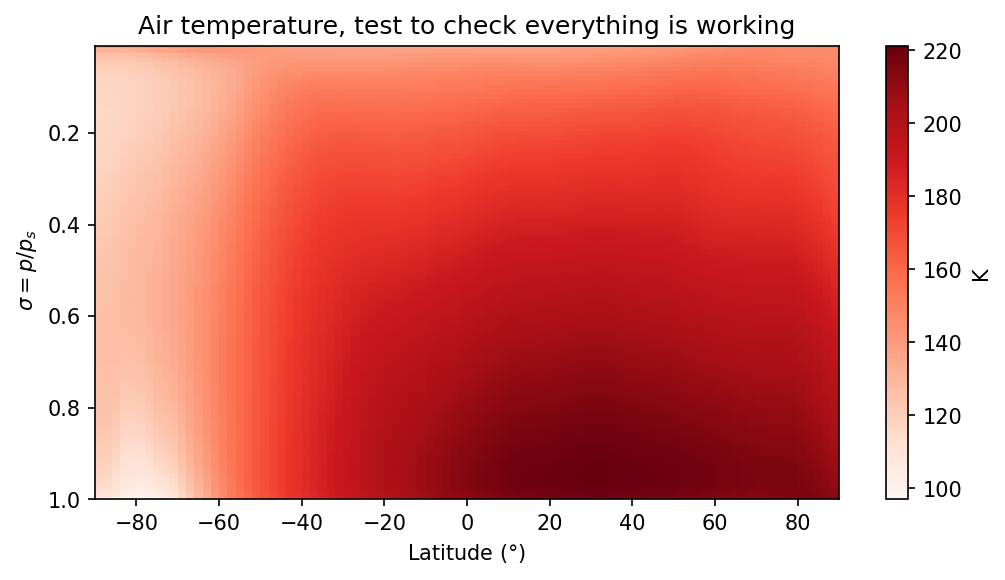

In [34]:
test = sigma_lev_cubes[0]
test = z_m(t_m(test))

fig = plt.figure(figsize=(8,4))
name = 'Air temperature, test to check everything is working'
iplt.pcolormesh(test, coords=["latitude", "sigma_p"], cmap='Reds')
# c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)
# mn, mx = ax.get_ylim()
# plt.yticks(np.arange(-90, 91, 30))
# plt.xlim(0.01,1)
plt.ylim(1,sigma_lev)
# plt.xticks(np.arange(-180, 180, 30))

plt.title(f'{name}', loc="center")
plt.xlabel("Latitude ($\degree$)")
plt.ylabel(" $\sigma = p / p_s$")
cb = plt.colorbar()

cb.ax.set_ylabel(f"K")



##### LMD:

In [35]:
month=['01','02','03','04','05','06','07','08','09','10','11','12']
print(month)


['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


In [36]:
UM_dust_sig

<iris 'Cube' of dust_mmr / (kg/kg) (sigma_p: 100; latitude: 90; longitude: 144)>

#### Parameters

##### Dust

In [37]:
# Variables reminder: 'LMD_dust' & 'LMD_dustradius'
UM_dust_sig

<iris 'Cube' of dust_mmr / (kg/kg) (sigma_p: 100; latitude: 90; longitude: 144)>

In [38]:
dust_max, dust_min, dust_step = get_data_max_min(UM_dust_sig,LMD_dust_sig,contour=False,dust=True)
dust_cont_max, dust_cont_min, dust_cont_step = get_data_max_min(UM_dust_sig,LMD_dust_sig,contour=False,dust=True)
dust_cont_vert_max, dust_cont_vert_min, dust_cont_vert_step = get_data_max_min(v_m(UM_dust_sig,model=Sigma_P),v_m(LMD_dust_sig,model=Sigma_P),contour=False,dust=True)


UM max 1.1802812911779158e-06
UM min 1.2063895745485689e-17
LMD max 3.117688174825162e-05
LMD min 2.83449075774751e-20
UM max 1.1802812911779158e-06
UM min 1.2063895745485689e-17
LMD max 3.117688174825162e-05
LMD min 2.83449075774751e-20
UM max 9.058717721312831e-07
UM min 1.136062595084728e-08
LMD max 5.214118118601618e-06
LMD min 5.80153994178545e-07


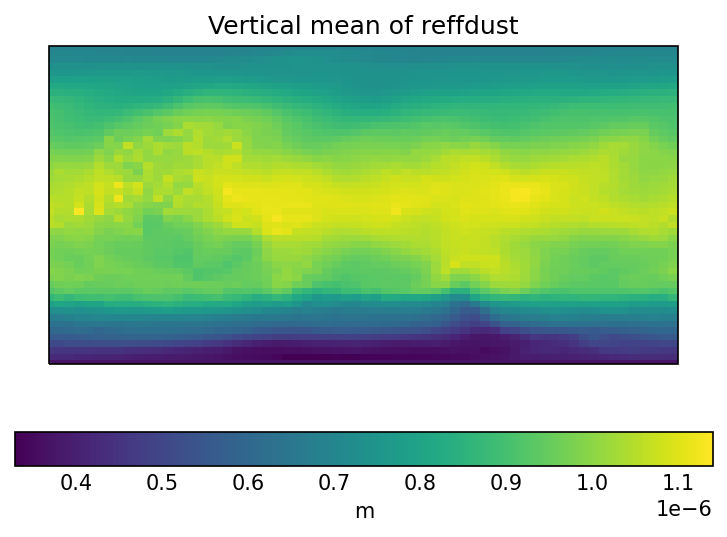

In [39]:
qplt.pcolormesh(t_m(v_m(LMD_dustradius, model=lmd),model=lmd))

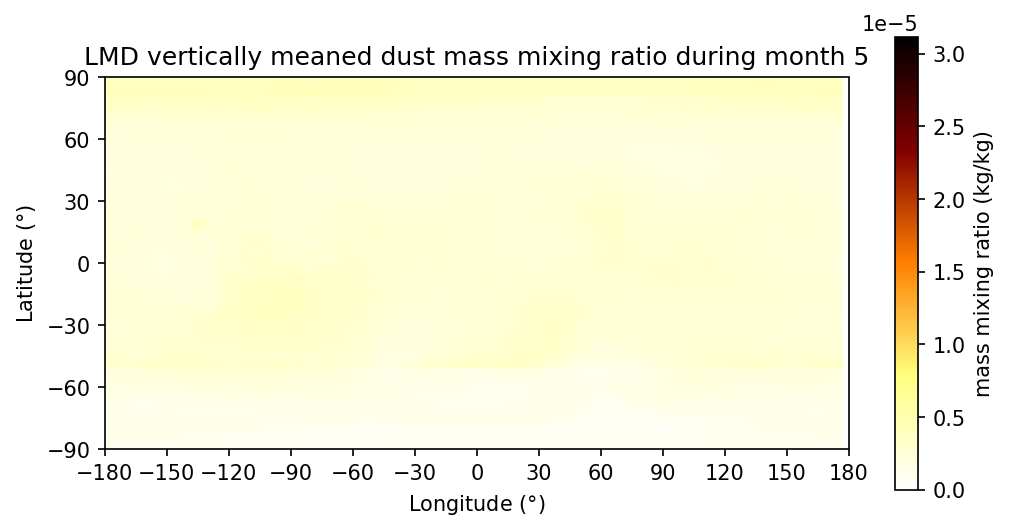

In [40]:
fig = plt.figure(figsize=(8,4))
iplt.pcolormesh(v_m(LMD_dust,model=lmd), cmap='afmhot_r',vmin = dust_min,vmax=dust_max)

name = (f'LMD vertically meaned dust mass mixing ratio during month {selected_month_int}')
save_path = (f'{name.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}.png')


# c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)
# mn, mx = ax.get_ylim()
plt.xticks(np.arange(-180, 180.9, 30))
plt.yticks(np.arange(-90, 91, 30))
plt.title(f'{name}', loc="center")
plt.xlabel("Longitude ($\degree$)")
plt.ylabel("Latitude ($\degree$)")
cb = plt.colorbar()
cb.ax.set_ylabel(f"mass mixing ratio (kg/kg)")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


In [41]:
LMD_dust_sig

<iris 'Cube' of dustq / (kg/kg) (sigma_p: 100; latitude: 49; longitude: 64)>

### lons, lats = get_xy_coords(LMD_dust,model=lmd)
lons, lats = lons.points, lats.points
hgt = np.arange(start=1,stop=sigma_lev,step=-sigma_0_difference) # overwrite
hgtn= (80/30)

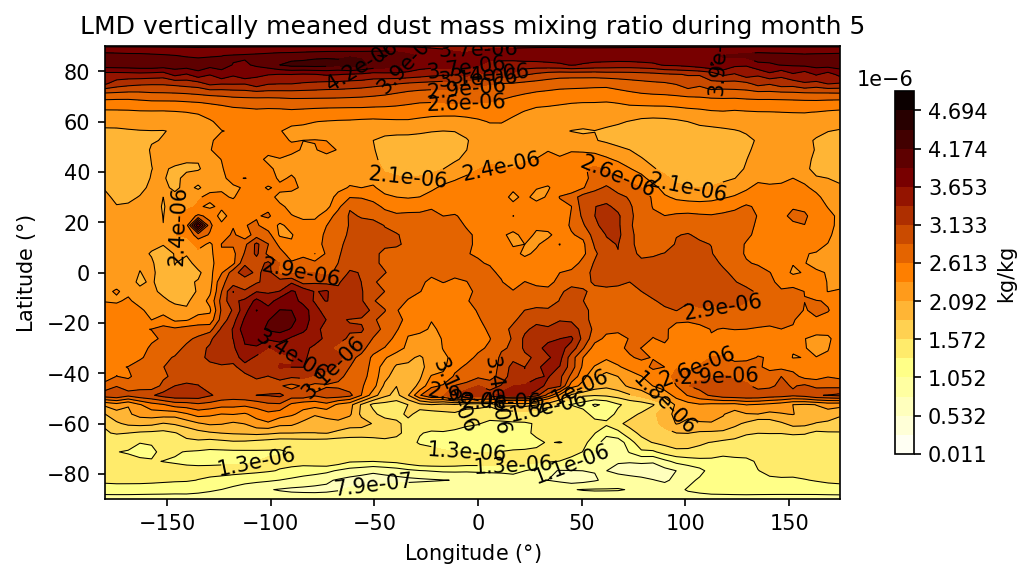

In [42]:
lons, lats = get_xy_coords(LMD_dust,model=lmd)
lons, lats = lons.points, lats.points
hgt = np.linspace(1,sigma_lev,100) # overwrite

hgtn= (80/30)

## LMD
fig, ax = plt.subplots(figsize=(8, 4))
# ax2 = ax.twinx()
surface_level=iris.Constraint(altitude=4.48063854e-03)
LMD_dust_0km = LMD_dust.extract(surface_level)
# print(LMD_dust_0km)

LMD_dust_vtm = t_m(v_m(LMD_dust,model=lmd),model=lmd)
# LMD_dust_tm_0km = t_m(LMD_dust_0km,model=lmd)

name = (f'LMD vertically meaned dust mass mixing ratio during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}_cont.png')


p0 = ax.contourf(
    lons,
    lats,
    LMD_dust_vtm.data,
    cmap="afmhot_r",
    levels=np.arange(dust_cont_vert_min,dust_cont_vert_max , dust_cont_vert_step)
)
p1 = ax.contour(
    lons,
    lats,
    LMD_dust_vtm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(dust_cont_vert_min,dust_cont_vert_max , dust_cont_vert_step)
)
c1 = ax.clabel(p1, fmt="%.1e", use_clabeltext=True)
mn, mx = ax.get_ylim()
cb = plt.colorbar(p0, pad=0.06,orientation='vertical',shrink=0.8)
cb.ax.set_title('')
cb.ax.set_ylabel(f"kg/kg")

# ax.set_xticks(np.arange(-180, 181, 30))
# ax.set_yticks(np.arange(-90, 91, 30))
# ax.set_ylim([0, 49.999])
# ax2.set_ylim(mn*hgtn,(mx*hgtn-1))

ax.set_xlabel("Longitude ($\degree$)")
ax.set_ylabel("Latitude ($\degree$)")
# ax2.set_ylabel("Height (km)")
ax.set_title(f'{name}', loc="center")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


In [43]:
len(step_sig)

100

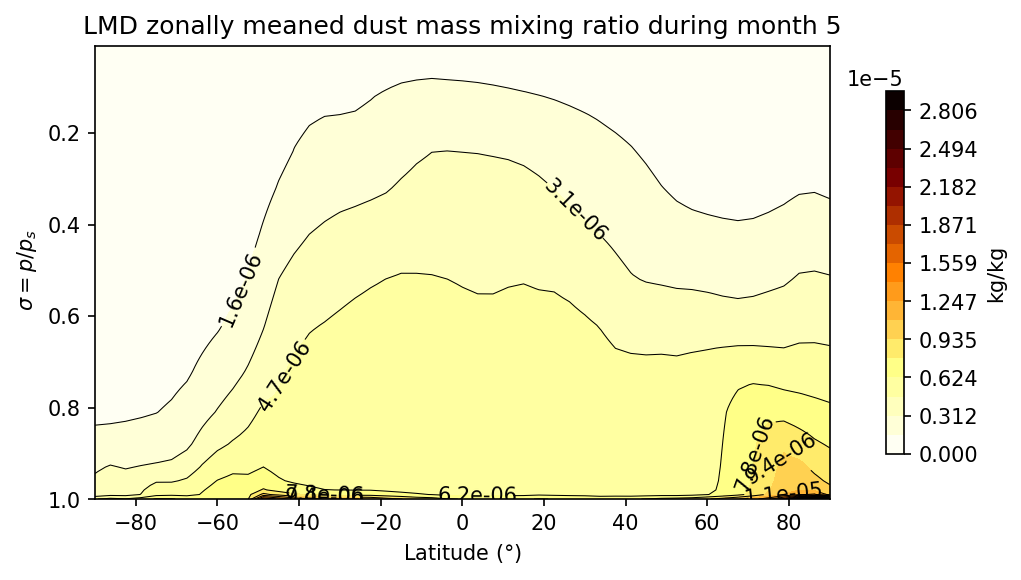

In [44]:
## LMD
fig, ax = plt.subplots(figsize=(8, 4))
# ax2 = ax.twinx()

lons, lats = get_xy_coords(LMD_dust,model=lmd)
lons, lats = lons.points, lats.points
hgt = np.linspace(1,sigma_lev,100) # overwrite
hgtn= (80/30)

name = (f'LMD zonally meaned dust mass mixing ratio during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}_cont.png')
LMD_dust_ztm = z_m(LMD_dust_sig,model=lmd)


p0 = ax.contourf(
    lats,
    hgt,
    LMD_dust_ztm.data,
    cmap="afmhot_r",
    levels=np.arange(dust_cont_min,dust_cont_max , dust_cont_step)
)
p1 = ax.contour(
    lats,
    hgt,
    LMD_dust_ztm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(dust_cont_min,dust_cont_max , dust_cont_step)
)
c1 = ax.clabel(p1, fmt="%.1e", use_clabeltext=True)
mn, mx = ax.get_ylim()
cb = plt.colorbar(p0, pad=0.06,orientation='vertical',shrink=0.8)
ax.set_xticks(np.arange(-80, 81, 20))
# ax.set_yticks(np.arange(0, 100, 10))
cb.ax.set_title('')
cb.ax.set_ylabel(f"kg/kg")

# ax.set_xticks(np.arange(-180, 181, 30))
# ax.set_yticks(np.arange(-90, 91, 30))
ax.set_ylim([1, sigma_lev])
# ax2.set_ylim(mn*hgtn,(mx*hgtn-1))
plt.ylabel(" $\sigma = p / p_s$")

ax.set_xlabel("Latitude ($\degree$)")
# ax2.set_ylabel("Height (km)")
ax.set_title(f'{name}', loc="center")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


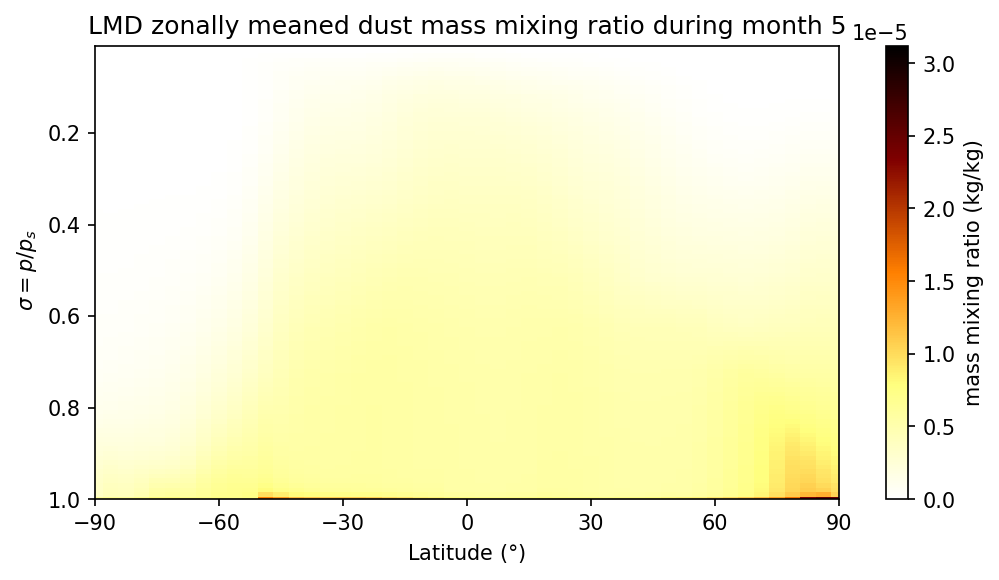

In [45]:
fig = plt.figure(figsize=(8,4))

name = (f'LMD zonally meaned dust mass mixing ratio during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}.png')


iplt.pcolormesh((LMD_dust_ztm),coords=["latitude", "sigma_p"], cmap='afmhot_r',vmin = dust_min,vmax=dust_max)
# c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)
# mn, mx = ax.get_ylim()
plt.xticks(np.arange(-90, 91, 30))
# plt.yticks(np.arange(1,0, 5))
plt.ylabel(" $\sigma = p / p_s$")

plt.ylim(1,sigma_lev)
plt.title(f'{name}', loc="center")
plt.xlabel("Latitude ($\degree$)")
cb = plt.colorbar()
cb.ax.set_ylabel(f"mass mixing ratio (kg/kg)")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")



In [46]:
UM_dust

<iris 'Cube' of dust_mmr / (kg/kg) (model_level_number: 51; latitude: 90; longitude: 144)>

In [47]:
# qplt.pcolormesh(UM_dust_vtm)

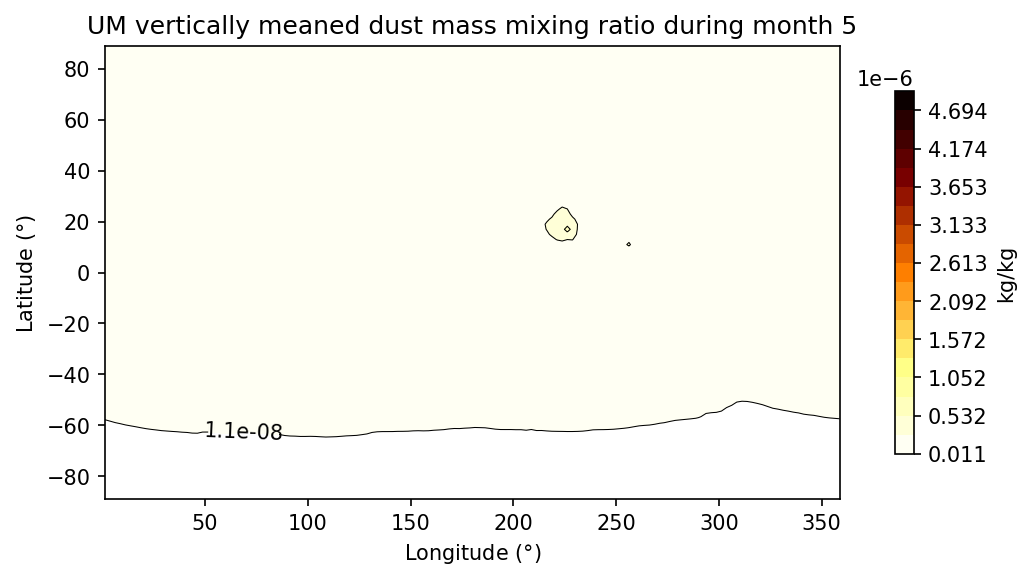

In [48]:
lons, lats = get_xy_coords(UM_dust)
lons, lats = lons.points, lats.points
hgt = np.linspace(1,sigma_lev,100) # overwrite
UM_dust_ztm = z_m(UM_dust_sig)
UM_dust_vtm = v_m(UM_dust)
## UM
fig, ax = plt.subplots(figsize=(8, 4))
# ax2 = ax.twinx()

name = (f'UM vertically meaned dust mass mixing ratio during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}_cont.png')


p0 = ax.contourf(
    lons,
    lats,
    UM_dust_vtm.data,
    cmap="afmhot_r",
    levels=np.arange(dust_cont_vert_min,dust_cont_vert_max , dust_cont_vert_step)
)
p1 = ax.contour(
    lons,
    lats,
    UM_dust_vtm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(dust_cont_vert_min,dust_cont_vert_max , dust_cont_vert_step)
)
c1 = ax.clabel(p1, fmt="%.1e", use_clabeltext=True)
mn, mx = ax.get_ylim()
cb = plt.colorbar(p0, pad=0.06,orientation='vertical',shrink=0.8)
cb.ax.set_title('')
cb.ax.set_ylabel(f"kg/kg")

# ax.set_xticks(np.arange(-180, 181, 30))
# ax.set_yticks(np.arange(-90, 91, 30))
# ax.set_ylim([0, 49.999])
# ax2.set_ylim(mn*hgtn,(mx*hgtn-1))

ax.set_xlabel("Longitude ($\degree$)")
ax.set_ylabel("Latitude ($\degree$)")
# ax2.set_ylabel("Height (km)")
ax.set_title(f'{name}', loc="center")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


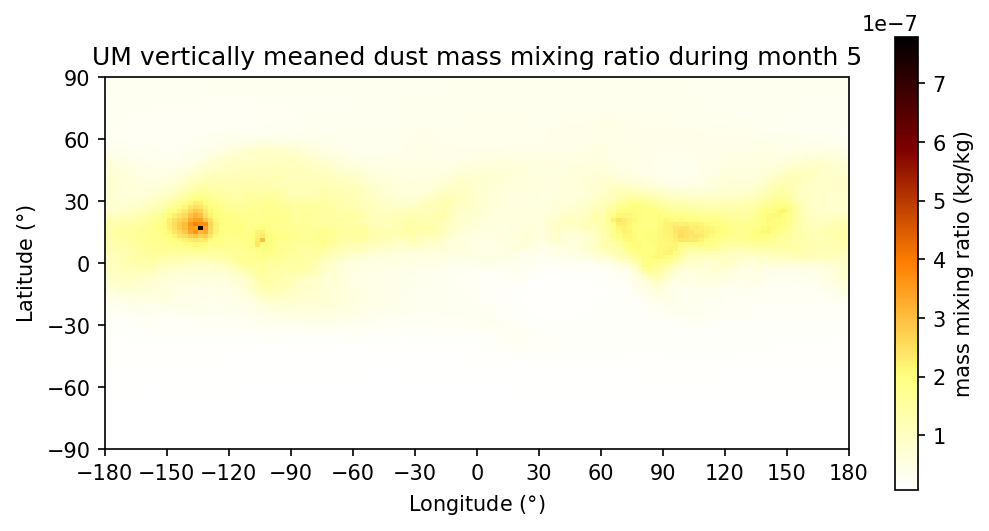

In [49]:
fig = plt.figure(figsize=(8,4))

name = (f'UM vertically meaned dust mass mixing ratio during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}.png')

iplt.pcolormesh((UM_dust_vtm), cmap='afmhot_r')
# c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)
# mn, mx = ax.get_ylim()
plt.xticks(np.arange(-180, 180.9, 30))
plt.yticks(np.arange(-90, 91, 30))

plt.title(f'UM vertically meaned dust mass mixing ratio during month {selected_month_int}', loc="center")
plt.xlabel("Longitude ($\degree$)")
plt.ylabel("Latitude ($\degree$)")
cb = plt.colorbar()
cb.ax.set_ylabel(f"mass mixing ratio (kg/kg)")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


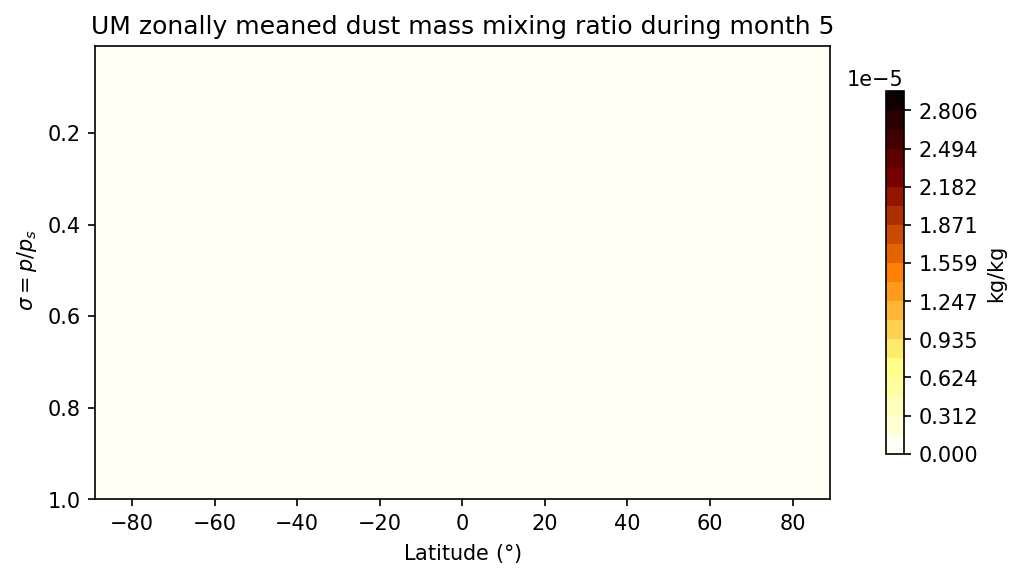

In [50]:
lons, lats = get_xy_coords(UM_dust_sig)
lons, lats = lons.points, lats.points
hgt = np.linspace(1,sigma_lev,100) # overwrite
miny= 0
maxy =8e+04
## UM
fig, ax = plt.subplots(figsize=(8, 4))
# ax2 = ax.twinx()

name = (f'UM zonally meaned dust mass mixing ratio during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}_cont.png')




p0 = ax.contourf(
    lats,
    hgt,
    UM_dust_ztm.data,
    cmap="afmhot_r",
    levels=np.arange(dust_cont_min,dust_cont_max , dust_cont_step)
)
p1 = ax.contour(
    lats,
    hgt,
    UM_dust_ztm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(dust_cont_min,dust_cont_max , dust_cont_step)
)
c1 = ax.clabel(p1, fmt="%.1e", use_clabeltext=True)
mn, mx = ax.get_ylim()
cb = plt.colorbar(p0, pad=0.06,orientation='vertical',shrink=0.8)
cb.ax.set_title('')
cb.ax.set_ylabel(f"kg/kg")

# ax.set_xticks(np.arange(-180, 181, 30))
# ax.set_yticks(np.arange(-90, 91, 30))
ax.set_ylim([1, sigma_lev])
# ax2.set_ylim(mn*hgtn,(mx*hgtn-1))
plt.ylabel(" $\sigma = p / p_s$")

ax.set_xlabel("Latitude ($\degree$)")
# ax2.set_ylabel("Height (km)")
ax.set_title(f'{name}', loc="center")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


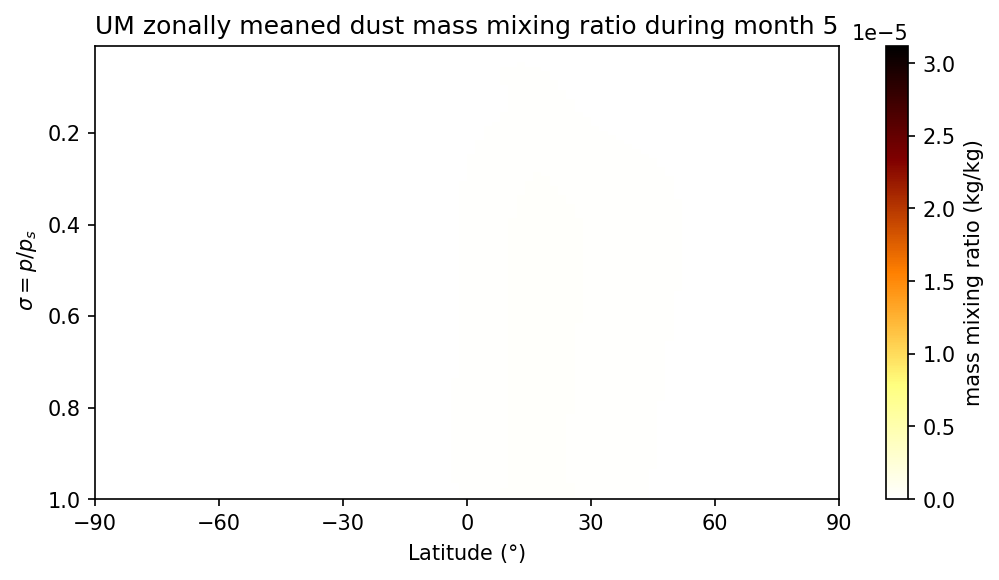

In [51]:
fig = plt.figure(figsize=(8,4))

name = (f'UM zonally meaned dust mass mixing ratio during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}.png')


iplt.pcolormesh((UM_dust_ztm),coords=["latitude", "sigma_p"], cmap='afmhot_r',vmin = dust_min,vmax=dust_max)
# c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)
# mn, mx = ax.get_ylim()
plt.xticks(np.arange(-90, 91, 30))
# plt.yticks(np.arange(1,0, 5))
plt.ylabel(" $\sigma = p / p_s$")

plt.ylim(1,sigma_lev)
plt.title(f'{name}', loc="center")
plt.xlabel("Latitude ($\degree$)")
cb = plt.colorbar()
cb.ax.set_ylabel(f"mass mixing ratio (kg/kg)")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")



In [52]:
LMD_dust.coord('altitude')

DimCoord(array([4.48063854e-03, 2.35406719e-02, 7.47709200e-02, 1.86963528e-01,
       3.97702843e-01, 7.53171921e-01, 1.30843985e+00, 2.12238836e+00,
       3.24806595e+00, 4.72804737e+00, 6.59054613e+00, 8.84520912e+00,
       1.14920502e+01, 1.45311575e+01, 1.79625435e+01, 2.17862453e+01,
       2.60023689e+01, 3.06109447e+01, 3.56120415e+01, 4.10057106e+01,
       4.67920799e+01, 5.29653587e+01, 5.94983749e+01, 6.63215179e+01,
       7.32992249e+01, 8.02992249e+01, 8.72992249e+01, 9.42992249e+01,
       1.01299225e+02, 1.08299225e+02], dtype=float32), standard_name='altitude', units=Unit('km'), long_name='pseudo_altitude', var_name='altitude', attributes={'positive': 'up'})

##### Winds

In [53]:
# Variables reminder: 'LMD_xwind', 'LMD_ywind', 'LMD_zwind'

In [54]:
UM_surftemp.collapsed(["latitude","longitude"], iris.analysis.MAX).data

array(226.90425075)

In [55]:
UM_xwind_sig_ztm = t_m(z_m(UM_xwind_sig))
UM_xwind_vtm = t_m(v_m(UM_xwind))
LMD_xwind_sig_ztm = t_m(z_m(LMD_xwind_sig,model=lmd),model=lmd)

xwind_max,xwind_min,xwind_step = get_data_max_min(UM_xwind_sig_ztm,LMD_xwind_sig_ztm)


UM max 94.8963694115219
UM min -6.879828146675507
LMD max 134.65853881835938
LMD min -23.628637313842773


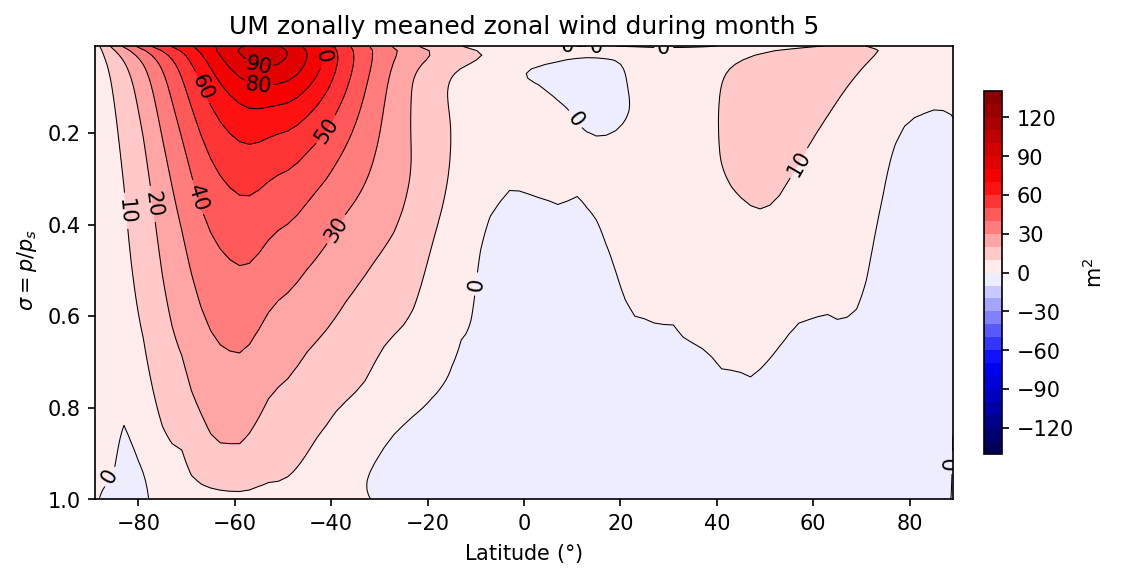

In [56]:
## UM

lons, lats = get_xy_coords(UM_xwind)
lons, lats = lons.points, lats.points
hgt = np.linspace(1,sigma_lev,100) # overwrite
miny= 0
maxy =8e+04

fig, ax = plt.subplots(figsize=(9, 4))
# ax2 = ax.twinx()

name = (f'UM zonally meaned zonal wind during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}_cont.png')

p0 = ax.contourf(
    lats,
    hgt,
    UM_xwind_sig_ztm.data,
    cmap="seismic",
    levels=np.arange(xwind_min,xwind_max+1 , xwind_step),
)
p1 = ax.contour(
    lats,
    hgt,
    UM_xwind_sig_ztm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(xwind_min,xwind_max+1 , xwind_step),
)
c1 = ax.clabel(p1, use_clabeltext=True)
mn, mx = ax.get_ylim()
cb = plt.colorbar(p0, pad=0.03,orientation='vertical',shrink=0.8)
cb.ax.set_title('')
cb.ax.set_ylabel(f"m$^2$")

# ax.set_xticks(np.arange(-180, 181, 30))
# ax.set_yticks(np.arange(-90, 91, 30))
# ax.set_ylim([0, 49.999])
# ax2.set_ylim(miny,maxy/1000)
plt.ylabel(" $\sigma = p / p_s$")
ax.set_ylim([1, sigma_lev])

ax.set_xlabel("Latitude ($\degree$)")
# ax2.set_ylabel("Height (km)")
ax.set_title(f'{name}', loc="center")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


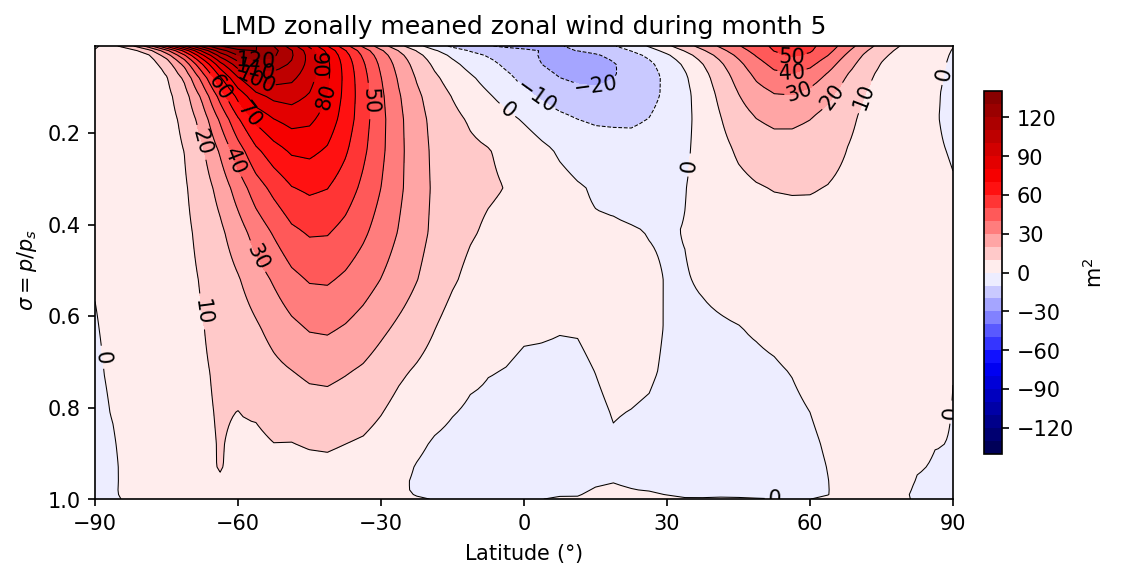

In [57]:
lons, lats = get_xy_coords(LMD_dust,model=lmd)
lons, lats = lons.points, lats.points
hgt = np.linspace(1,sigma_lev,100) # overwrite
hgtn= (80/30)
miny= 0
maxy =8e+04


## UM
fig, ax = plt.subplots(figsize=(9, 4))
# ax2 = ax.twinx()

name = (f'LMD zonally meaned zonal wind during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}_cont.png')

LMD_xwind_ztm = t_m(z_m(LMD_xwind_sig,model=lmd),model=lmd)


p0 = ax.contourf(
    lats,
    hgt,
    LMD_xwind_sig_ztm.data,
    cmap="seismic",
    levels=np.arange(xwind_min,xwind_max+1 , xwind_step),
)
p1 = ax.contour(
    lats,
    hgt,
    LMD_xwind_sig_ztm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(xwind_min,xwind_max+1 , xwind_step),
)
c1 = ax.clabel(p1, use_clabeltext=True)
mn, mx = ax.get_ylim()
cb = plt.colorbar(p0, pad=0.03,orientation='vertical',shrink=0.8)
ax.set_xticks(np.arange(-90, 91, 30))
# ax.set_yticks(np.arange(0, 30, 10))
cb.ax.set_title('')
cb.ax.set_ylabel(f"m$^2$")

# ax.set_xticks(np.arange(-180, 181, 30))
# ax.set_yticks(np.arange(-90, 91, 30))
# ax.set_ylim([0, 49.999])
plt.ylabel(" $\sigma = p / p_s$")
ax.set_ylim([1, sigma_lev])
ax.set_xlabel("Latitude ($\degree$)")
# ax2.set_ylabel("Height (km)")
ax.set_title(f'{name}', loc="center")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


Y wind

In [58]:

UM_ywind_sig_ztm = t_m(z_m(UM_ywind_sig))
UM_ywind_vtm = t_m(v_m(UM_ywind))
LMD_ywind_sig_ztm = t_m(z_m(LMD_ywind_sig,model=lmd),model=lmd)
ywind_max,ywind_min,ywind_step = get_data_max_min(UM_ywind_sig_ztm,LMD_ywind_sig_ztm)


UM max 6.278458948341489
UM min -3.9380957408611073
LMD max 5.691770553588867
LMD min -7.834056854248047


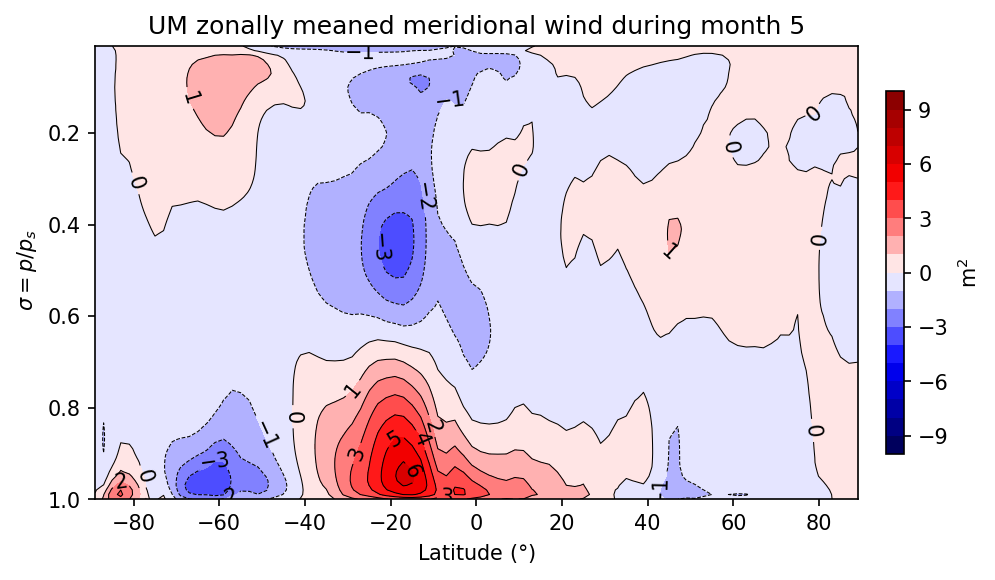

In [59]:
## UM

lons, lats = get_xy_coords(UM_ywind)
lons, lats = lons.points, lats.points
hgt = np.linspace(1,sigma_lev,100) # overwrite


fig, ax = plt.subplots(figsize=(8, 4))
# ax2 = ax.twinx()

name = (f'UM zonally meaned meridional wind during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}_cont.png')



p0 = ax.contourf(
    lats,
    hgt,
    UM_ywind_sig_ztm.data,
    cmap="seismic",
    levels=np.arange(ywind_min,ywind_max+1 , ywind_step),
)
p1 = ax.contour(
    lats,
    hgt,
    UM_ywind_sig_ztm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(ywind_min,ywind_max+1 , ywind_step),
)
c1 = ax.clabel(p1, use_clabeltext=True)
mn, mx = ax.get_ylim()
cb = plt.colorbar(p0, pad=0.03,orientation='vertical',shrink=0.8)
cb.ax.set_title('')
cb.ax.set_ylabel(f"m$^2$")

# ax.set_xticks(np.arange(-180, 181, 30))
# ax.set_yticks(np.arange(-90, 91, 30))
# ax.set_ylim([0, 49.999])
# ax2.set_ylim(mn*hgtn,(mx*hgtn-1))
plt.ylabel(" $\sigma = p / p_s$")
ax.set_ylim([1, sigma_lev])
ax.set_xlabel("Latitude ($\degree$)")
# ax2.set_ylabel("Height (km)")
ax.set_title(f'{name}', loc="center")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


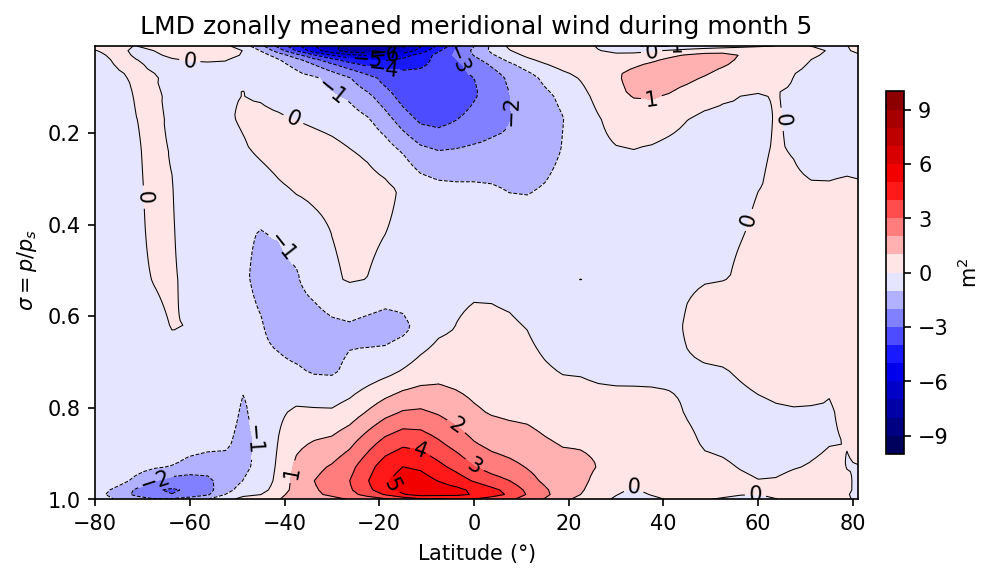

In [60]:


lons, lats = get_xy_coords(LMD_dust,model=lmd)
lons, lats = lons.points, lats.points
hgt = np.linspace(1,sigma_lev,100) # overwrite
hgtn= (80/30)
miny= 0
maxy =8e+04
LMD_ywind_ztm = t_m(z_m(LMD_ywind_sig,model=lmd),model=lmd)

## UM
fig, ax = plt.subplots(figsize=(8, 4))
# ax2 = ax.twinx()

name = (f'LMD zonally meaned meridional wind during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}_cont.png')


p0 = ax.contourf(
    lats,
    hgt,
    LMD_ywind_sig_ztm.data,
    cmap="seismic",
    levels=np.arange(ywind_min,ywind_max+1 , ywind_step),
)
p1 = ax.contour(
    lats,
    hgt,
    LMD_ywind_sig_ztm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(ywind_min,ywind_max+1 , ywind_step),
)
c1 = ax.clabel(p1, use_clabeltext=True)
mn, mx = ax.get_ylim()
cb = plt.colorbar(p0, pad=0.03,orientation='vertical',shrink=0.8)
# ax.set_xticks(np.arange(-90, 91, 30))
# ax.set_yticks(np.arange(0, 30, 10))
cb.ax.set_title('')
# cb.ax.set_ylim(-18, 17)
cb.ax.set_ylabel(f"m$^2$")

# ax.set_xticks(np.arange(-180, 181, 30))
# ax.set_yticks(np.arange(-90, 91, 30))
ax.set_ylim([0, 49.999])
ax.set_xlim([-80, 81])

# ax2.set_ylim(mn*hgtn,(mx*hgtn-1))
plt.ylabel(" $\sigma = p / p_s$")
ax.set_ylim([1, sigma_lev])
ax.set_xlabel("Latitude ($\degree$)")
# ax2.set_ylabel("Height (km)")
ax.set_title(f'{name}', loc="center")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")
    print(save_path)


In [61]:
UM_surftemp

<iris 'Cube' of surface_temperature / (K) (latitude: 90; longitude: 144)>

##### Temperature

In [62]:
# Variables reminder: 'LMD_temp', 'LMD_surftemp'
surftemp_max, surftemp_min, surftemp_step = get_data_max_min(UM_surftemp,LMD_surftemp,contour=False,flat=True)


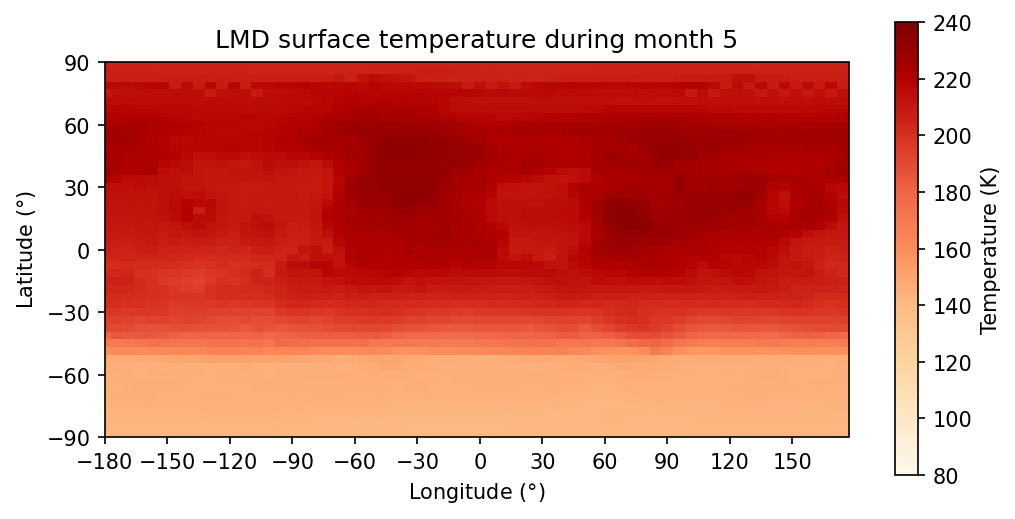

In [63]:
fig = plt.figure(figsize=(8,4))
iplt.pcolormesh(LMD_surftemp, cmap='OrRd',vmin=surftemp_min,vmax=surftemp_max)

name = (f'LMD surface temperature during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}.png')


# c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)
# mn, mx = ax.get_ylim()
plt.xticks(np.arange(-180, 180, 30))
plt.yticks(np.arange(-90, 91, 30))
plt.ylim(-90,91)
plt.title(f'{name}', loc="center")
plt.xlabel("Longitude ($\degree$)")
plt.ylabel("Latitude ($\degree$)")
cb = plt.colorbar()
cb.ax.set_ylabel(f"Temperature (K)")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


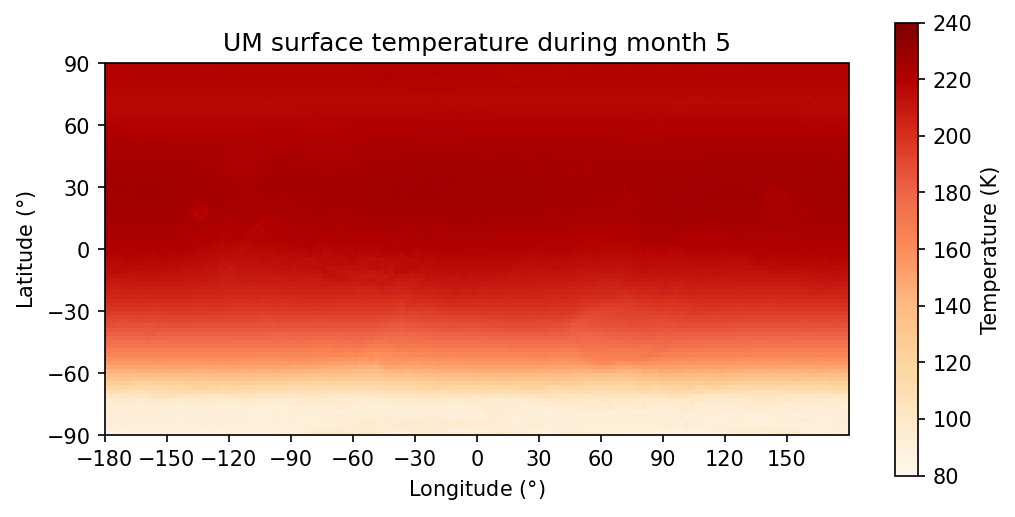

In [64]:
fig = plt.figure(figsize=(8,4))
iplt.pcolormesh(UM_surftemp, cmap='OrRd',vmin=surftemp_min,vmax=surftemp_max)

name = (f'UM surface temperature during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}.png')


# c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)
# mn, mx = ax.get_ylim()
plt.xticks(np.arange(-180, 180, 30))
plt.yticks(np.arange(-90, 91, 30))
plt.title(f'{name}', loc="center")
plt.xlabel("Longitude ($\degree$)")
plt.ylabel("Latitude ($\degree$)")
cb = plt.colorbar()
cb.ax.set_ylabel(f"Temperature (K)")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


In [65]:
UM_temp_sig_zm = z_m(UM_temp_sig)
LMD_temp_sig_zm= z_m(LMD_temp_sig,model=lmd)
air_temp_max, air_temp_min, air_temp_step = get_data_max_min(UM_temp_sig_zm,LMD_temp_sig_zm,contour=False)
print(air_temp_max)
print(air_temp_min)
print(air_temp_step)

UM max 221.15269690168645
UM min 96.99439576906049
LMD max 226.1131134033203
LMD min 119.86451721191406
230
90
10


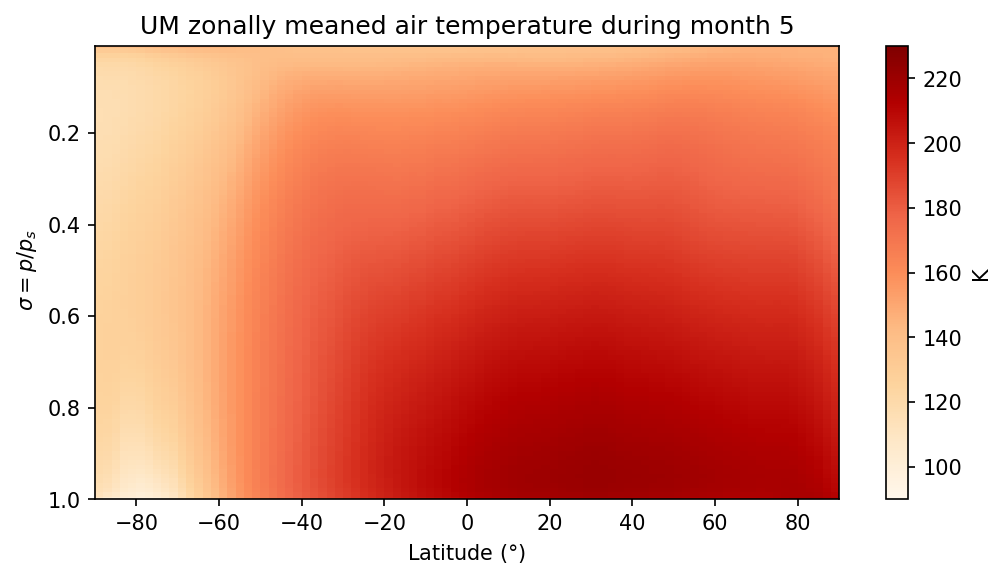

In [66]:
fig = plt.figure(figsize=(8,4))
name = (f'UM zonally meaned air temperature during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}.png')

iplt.pcolormesh(z_m(UM_temp_sig), coords=["latitude", "sigma_p"], cmap='OrRd',vmin=air_temp_min,vmax= air_temp_max)
# c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)
# mn, mx = ax.get_ylim()
# plt.yticks(np.arange(-90, 91, 30))
# plt.xlim(0.01,1)
plt.ylim(1,sigma_lev)
# plt.xticks(np.arange(-180, 180, 30))

plt.title(f'{name}', loc="center")
plt.xlabel("Latitude ($\degree$)")
plt.ylabel(" $\sigma = p / p_s$")
cb = plt.colorbar()

cb.ax.set_ylabel(f"K")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


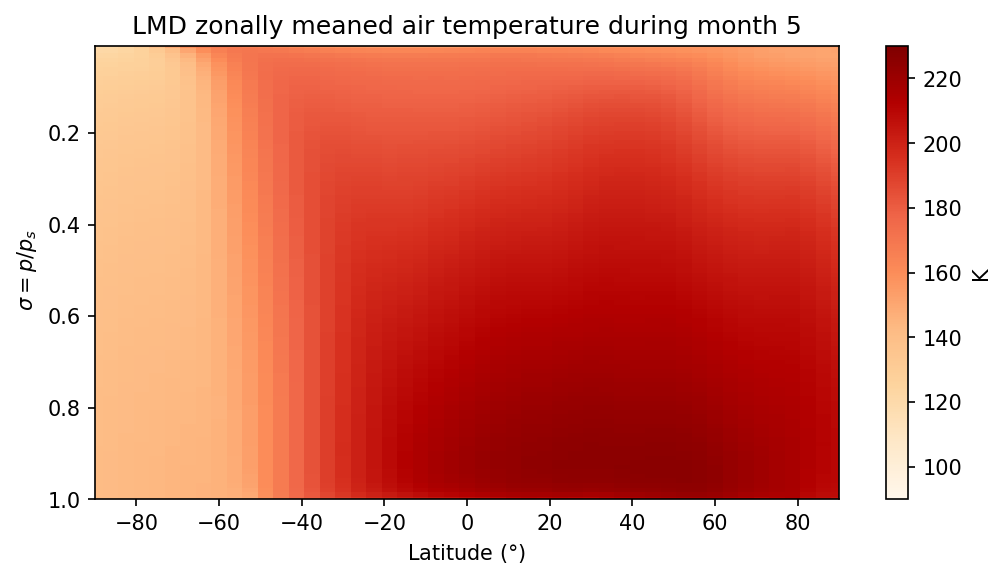

In [67]:
fig = plt.figure(figsize=(8,4))
name = (f'LMD zonally meaned air temperature during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}.png')

iplt.pcolormesh(z_m(LMD_temp_sig,model=lmd),coords=["latitude", "sigma_p"], cmap='OrRd',vmin=air_temp_min,vmax= air_temp_max)
# c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)
# mn, mx = ax.get_ylim()
# plt.yticks(np.arange(-90, 91, 30))
# plt.xlim(0.01,1)
# plt.xticks(np.arange(-180, 180, 30))

plt.title(f'{name}', loc="center")
plt.xlabel("Latitude ($\degree$)")
plt.ylabel(" $\sigma = p / p_s$")
plt.ylim(1,sigma_lev)

cb = plt.colorbar()

cb.ax.set_ylabel(f"K")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")



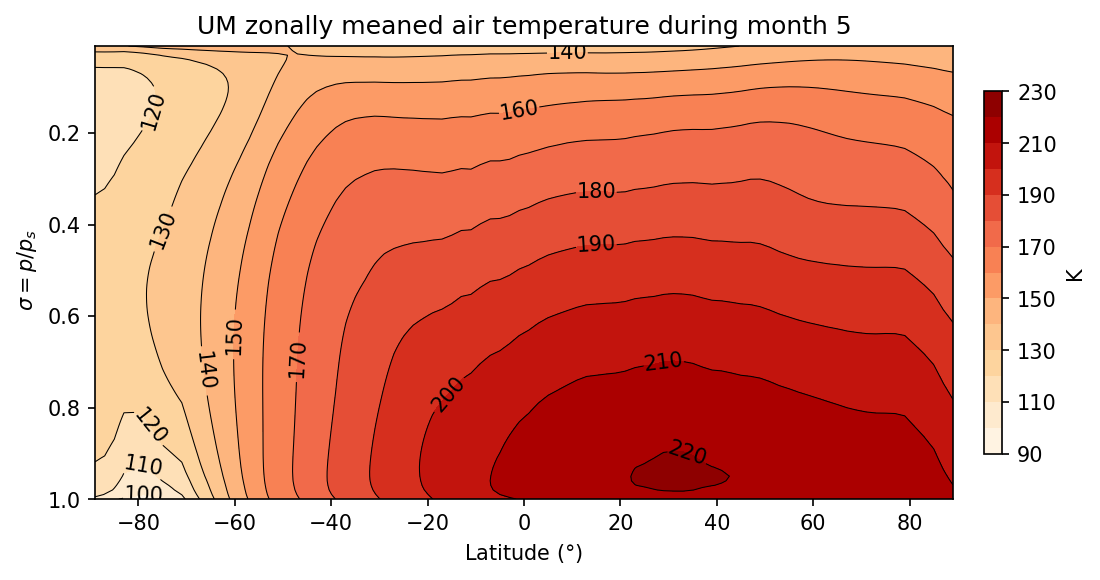

In [68]:
## UM

lons, lats = get_xy_coords(UM_temp_sig)
lons, lats = lons.points, lats.points
hgt = np.linspace(1,sigma_lev,100) # overwrite
miny= 0
maxy =8e+04

fig, ax = plt.subplots(figsize=(9, 4))
# ax2 = ax.twinx()

name = (f'UM zonally meaned air temperature during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}_cont.png')

p0 = ax.contourf(
    lats,
    hgt,
    UM_temp_sig_zm.data,
    cmap="OrRd",
    levels=np.arange(air_temp_min,air_temp_max+1 , air_temp_step),
)
p1 = ax.contour(
    lats,
    hgt,
    UM_temp_sig_zm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(air_temp_min,air_temp_max+1 , air_temp_step),
)
c1 = ax.clabel(p1, use_clabeltext=True)
mn, mx = ax.get_ylim()
cb = plt.colorbar(p0, pad=0.03,orientation='vertical',shrink=0.8)
cb.ax.set_title('')
cb.ax.set_ylabel(f"K")

# ax.set_xticks(np.arange(-180, 181, 30))
# ax.set_yticks(np.arange(-90, 91, 30))
# ax.set_ylim([0, 49.999])
# ax2.set_ylim(miny,maxy/1000)
plt.ylabel(" $\sigma = p / p_s$")
ax.set_ylim([1, sigma_lev])

ax.set_xlabel("Latitude ($\degree$)")
# ax2.set_ylabel("Height (km)")
ax.set_title(f'{name}', loc="center")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


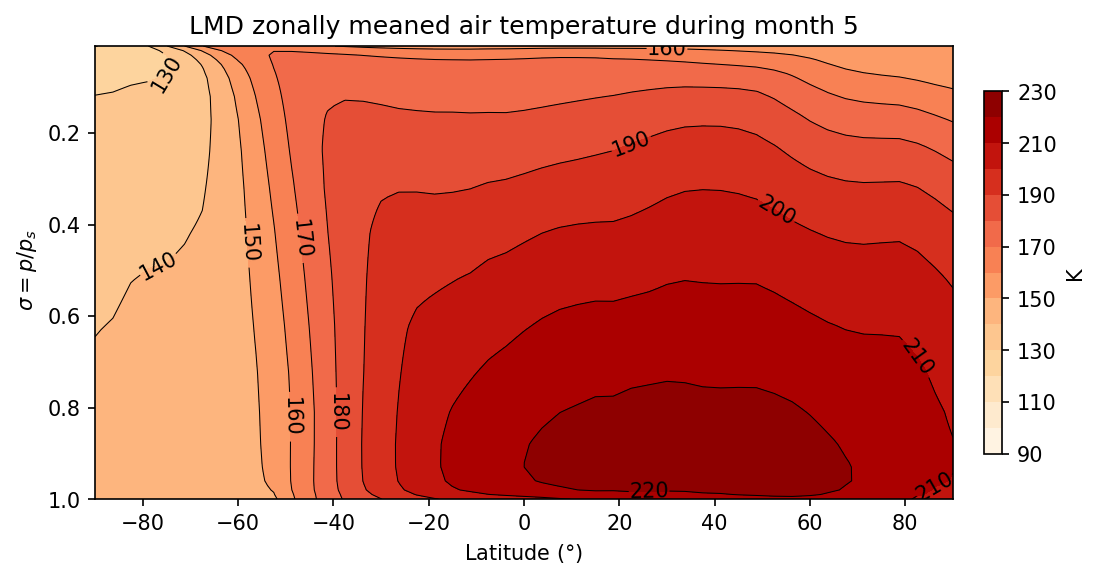

In [69]:
## UM

lons, lats = get_xy_coords(LMD_temp_sig_zm)
lons, lats = lons.points, lats.points
hgt = np.linspace(1,sigma_lev,100) # overwrite
miny= 0
maxy =8e+04

fig, ax = plt.subplots(figsize=(9, 4))
# ax2 = ax.twinx()

name = (f'LMD zonally meaned air temperature during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}_cont.png')

p0 = ax.contourf(
    lats,
    hgt,
    LMD_temp_sig_zm.data,
    cmap="OrRd",
    levels=np.arange(air_temp_min,air_temp_max+1 , air_temp_step),
)
p1 = ax.contour(
    lats,
    hgt,
    LMD_temp_sig_zm.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(air_temp_min,air_temp_max+1 , air_temp_step),
)
c1 = ax.clabel(p1, use_clabeltext=True)
mn, mx = ax.get_ylim()
cb = plt.colorbar(p0, pad=0.03,orientation='vertical',shrink=0.8)
cb.ax.set_title('')
cb.ax.set_ylabel(f"K")

# ax.set_xticks(np.arange(-180, 181, 30))
# ax.set_yticks(np.arange(-90, 91, 30))
# ax.set_ylim([0, 49.999])
# ax2.set_ylim(miny,maxy/1000)
plt.ylabel(" $\sigma = p / p_s$")
ax.set_ylim([1, sigma_lev])

ax.set_xlabel("Latitude ($\degree$)")
# ax2.set_ylabel("Height (km)")
ax.set_title(f'{name}', loc="center")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


In [70]:
selected_month_int

5

##### Pressure

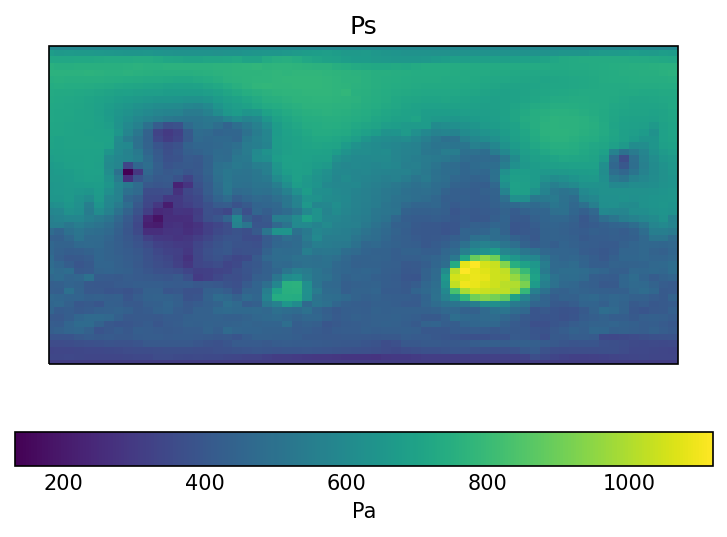

In [71]:
# Variables reminder: 'LMD_surfpres'
# Quick test variable to make sure the variables are correct
qplt.pcolormesh(LMD_surfpres)
surfpres_max, surfpres_min, surfpres_step = get_data_max_min(t_m(UM_surfpres),LMD_surfpres,contour=False,flat=True)


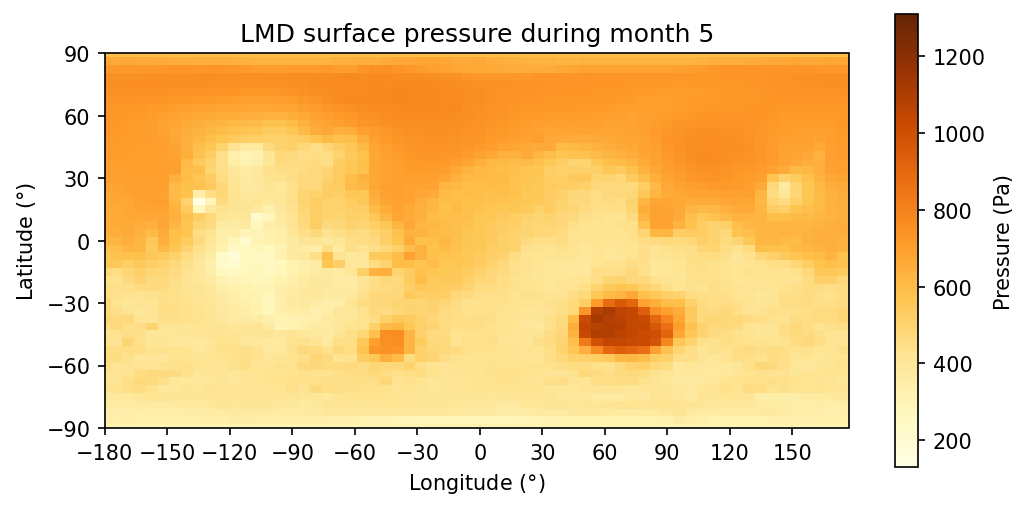

In [72]:
fig = plt.figure(figsize=(8,4))

name = (f'LMD surface pressure during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}.png')


iplt.pcolormesh((LMD_surfpres), cmap='YlOrBr', vmin=surfpres_min, vmax=surfpres_max)
# c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)
# mn, mx = ax.get_ylim()
plt.yticks(np.arange(-90, 91, 30))
# plt.xlim(-180,19)
plt.xticks(np.arange(-180, 180, 30))

plt.title(f'{name}', loc="center")
plt.xlabel("Longitude ($\degree$)")
plt.ylabel("Latitude ($\degree$)")
cb = plt.colorbar()
cb.ax.set_ylabel(f"Pressure (Pa)")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")



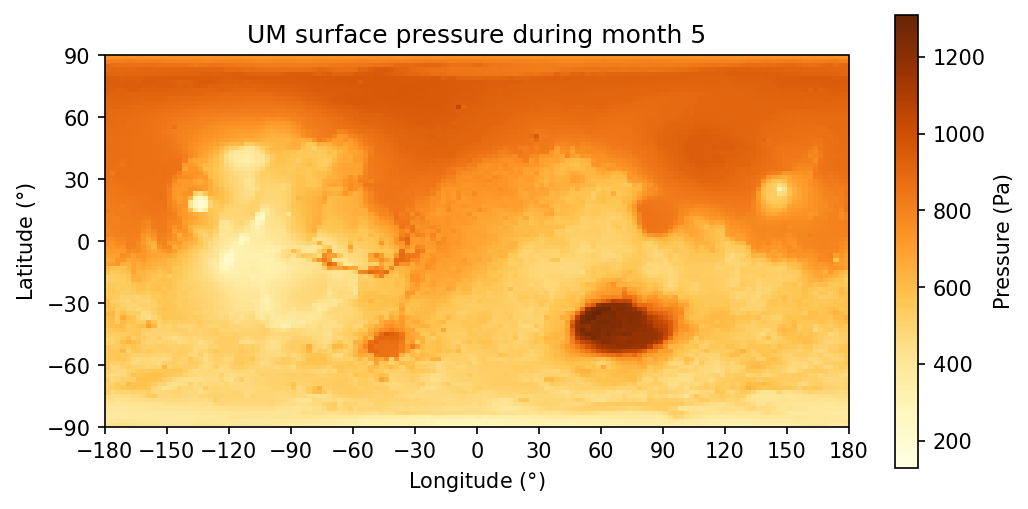

In [73]:
fig = plt.figure(figsize=(8,4))

name = (f'UM surface pressure during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}.png')


iplt.pcolormesh(t_m(UM_surfpres), cmap='YlOrBr', vmin=surfpres_min, vmax=surfpres_max)
# c1 = ax.clabel(p1, fmt="%.0f", use_clabeltext=True)
# mn, mx = ax.get_ylim()
plt.yticks(np.arange(-90, 91, 30))
# plt.xlim(-180,180)
plt.xticks(np.arange(-180, 181, 30))
plt.title(f'{name}', loc="center")
plt.xlabel("Longitude ($\degree$)")
plt.ylabel("Latitude ($\degree$)")
cb = plt.colorbar()
# cb.ax.set_ylim([350,3000])


cb.ax.set_ylabel(f"Pressure (Pa)")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")
    print(save_path)


Steps = 60


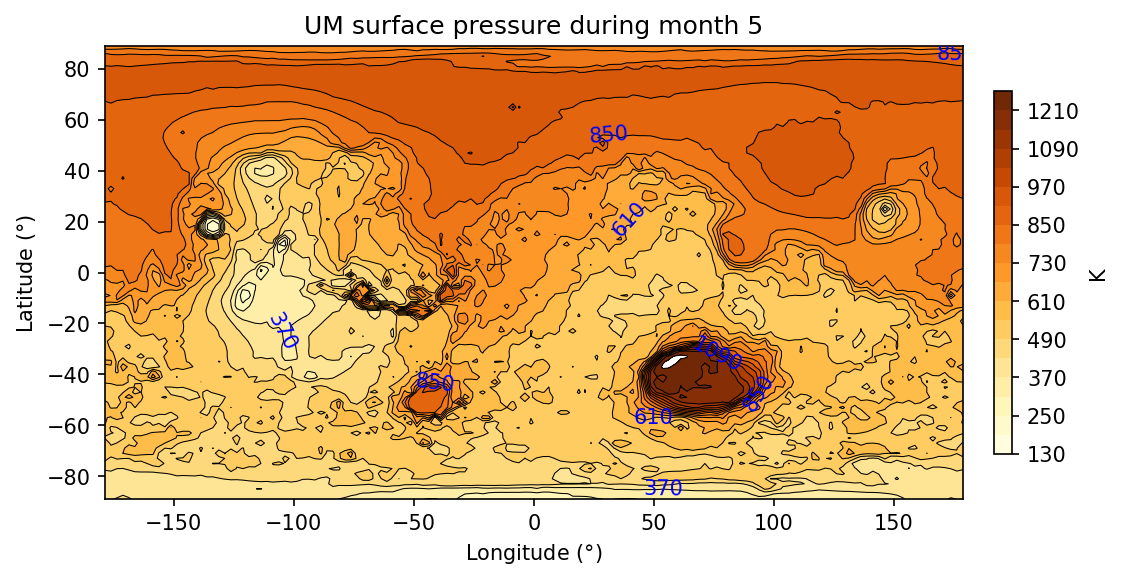

In [74]:
## UM
UM_surfpres_rotated=UM_surfpres
UM_surfpres_rotated=roll_cube_pm180(UM_surfpres_rotated)
lons, lats = get_xy_coords(UM_surfpres_rotated)
lons, lats = lons.points, lats.points
hgt = np.linspace(1,sigma_lev,100) # overwrite
miny= 0
maxy =8e+04

fig, ax = plt.subplots(figsize=(9, 4))
# ax2 = ax.twinx()

name = (f'UM surface pressure during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}_cont.png')

p0 = ax.contourf(
    lons,
    lats,
    UM_surfpres_rotated.data,
    cmap="YlOrBr",
    levels=np.arange(surfpres_min,surfpres_max+1 , surfpres_step),
)
p1 = ax.contour(
    lons,
    lats,
    UM_surfpres_rotated.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(surfpres_min,surfpres_max+1 , surfpres_step),
)
p2 = ax.contour(
    lons,
    lats,
    UM_surfpres_rotated.data,
    colors="blue",
    linewidths=0.0001,
    levels=np.arange(surfpres_min,surfpres_max+1 , surfpres_step*4),
)
c1 = ax.clabel(p2, use_clabeltext=True)
mn, mx = ax.get_ylim()
cb = plt.colorbar(p0, pad=0.03,orientation='vertical',shrink=0.8)
cb.ax.set_title('')
cb.ax.set_ylabel(f"K")

# ax.set_xticks(np.arange(-180, 181, 30))
# ax.set_yticks(np.arange(-90, 91, 30))
# ax.set_ylim([0, 49.999])
# ax2.set_ylim(miny,maxy/1000)
plt.xlabel("Longitude ($\degree$)")
# ax.set_ylim([1, sigma_lev])

ax.set_ylabel("Latitude ($\degree$)")
# ax2.set_ylabel("Height (km)")
ax.set_title(f'{name}', loc="center")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")
print(f'Steps = {surfpres_step}')

Steps = 60


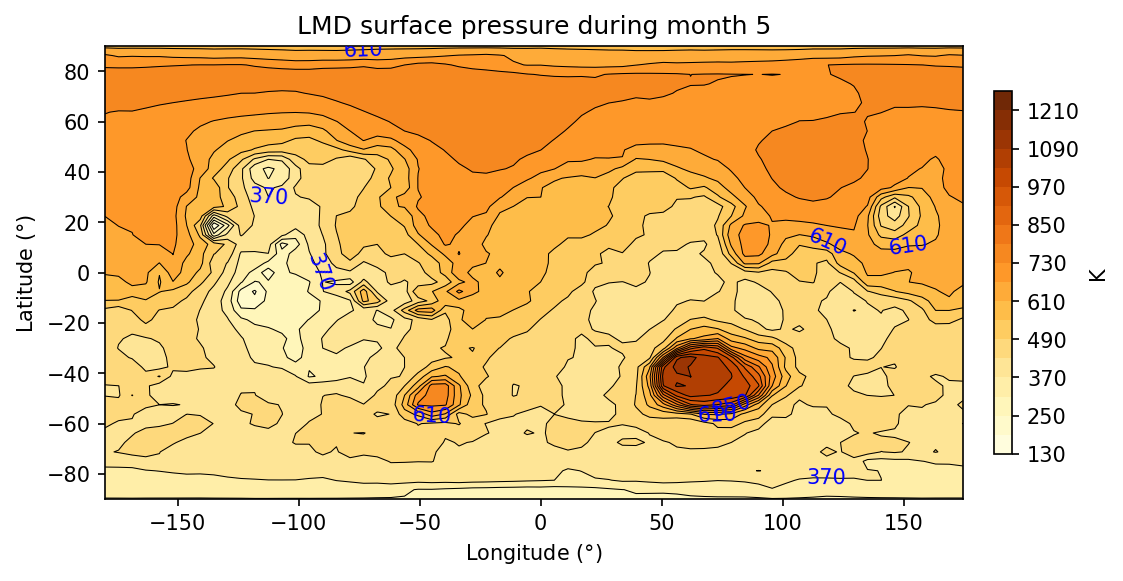

In [75]:
## UM

lons, lats = get_xy_coords(LMD_surfpres)
lons, lats = lons.points, lats.points
hgt = np.linspace(1,sigma_lev,100) # overwrite
miny= 0
maxy =8e+04

fig, ax = plt.subplots(figsize=(9, 4))
# ax2 = ax.twinx()

name = (f'LMD surface pressure during month {selected_month_int}')
save_path = name[:-15]
save_path = (f'{save_path.replace(" ","_")}')
save_path = (f'{save_path.replace(",","")}')
save_path=str(f'{save_dir}{selected_month}_{save_path}_cont.png')

p0 = ax.contourf(
    lons,
    lats,
    LMD_surfpres.data,
    cmap="YlOrBr",
    levels=np.arange(surfpres_min,surfpres_max+1 , surfpres_step),
)
p1 = ax.contour(
    lons,
    lats,
    LMD_surfpres.data,
    colors="k",
    linewidths=0.5,
    levels=np.arange(surfpres_min,surfpres_max+0 , surfpres_step),
)
p2 = ax.contour(
    lons,
    lats,
    LMD_surfpres.data,
    colors="blue",
    linewidths=0.0001,
    levels=np.arange(surfpres_min,surfpres_max+1 , surfpres_step*4),
)
c1 = ax.clabel(p2, use_clabeltext=True)
mn, mx = ax.get_ylim()
cb = plt.colorbar(p0, pad=0.03,orientation='vertical',shrink=0.8)
cb.ax.set_title('')
cb.ax.set_ylabel(f"K")

# ax.set_xticks(np.arange(-180, 181, 30))
# ax.set_yticks(np.arange(-90, 91, 30))
# ax.set_ylim([0, 49.999])
# ax2.set_ylim(miny,maxy/1000)
plt.xlabel("Longitude ($\degree$)")
# ax.set_ylim([1, sigma_lev])

ax.set_ylabel("Latitude ($\degree$)")
# ax2.set_ylabel("Height (km)")
ax.set_title(f'{name}', loc="center")
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")
print(f'Steps = {surfpres_step}')

In [76]:
%%notify
print('Done')

Done


<IPython.core.display.Javascript object>

In [77]:
end_time = time.time()
total_time_taken = end_time-start_time

In [78]:
def timer(inp):
    mins, secs = divmod(inp, 60)
    hours, mins = divmod(mins,60)
    mins = int(mins)
    secs = int(secs)
    hours = int(hours)
    timer = datetime.time(hours,mins,secs)
    timer_test = print(f'Time taken: {timer}')
    return timer_test
timer(total_time_taken)



Time taken: 00:38:05


In [79]:
# UM_dust.coord('level_height')

In [80]:
orog=pa.extract(CM_INST_CONSTR).extract_cube('surface_altitude')

ConstraintMismatchError: Got 0 cubes for constraint Constraint(name='surface_altitude'), expecting 1.

In [ ]:
ELEV_THRESH = 1  # [m]

test = UM_surfpres.data[abs(orog.data)<ELEV_THRESH]
test

In [ ]:
610-np.mean(test)

In [ ]:
# LMD_dust
# UM_dust.coord('level_height')

In [ ]:
# avoid continueing the rest unless needed, as it creates quite large objects that are memory intensive
if year_analysis == False:
    break
else:
    pass

In [ ]:
%%time
UM_sigma_pressure_pre = UM_pres_pre/UM_surfpres_pre
UM_sigma_pressure_pre.rename(um.s_p)
# sigma_pressure

dust_height_cube = regrid_3d(UM_dust_pre, UM_sigma_pressure_pre,model=um)
# print('--------------')

# dust_height_cube = s_m(dust_height_cube)
# print('--------------')
# print(dust_height_cube)
dust_cube_sigma = stratify.relevel(
        dust_height_cube,
        UM_sigma_pressure_pre,
        sigma_levels,
        axis=um.z,
        interpolator=INTERPOLATOR,
    )
del dust_height_cube # Remove the object as its quite large 
dust_cube_sigma = s_m(dust_cube_sigma)
print(dust_cube_sigma)

In [ ]:
dust_cube_sigma_vm = v_m(dust_cube_sigma,model=Sigma_P)

In [ ]:

LMD_surfpres_year_pre=iris.load(f'{LMD_path}*_me.nc','ps')
LMD_dust_year_pre=iris.load(f'{LMD_path}*_me.nc','dustq')


lmd.s_p = "sigma_p"
lmd.height = "height_above_reference_ellipsoid"
LMD_sigma_pressure = LMD_pres/LMD_surfpres
LMD_sigma_pressure.rename(lmd.s_p)
LMD_dust_cubes = iris.cube.CubeList()

d=15

for cube in LMD_dust_year_pre:
    cube= t_m(cube,model=lmd)
    cube.coord("Time").units = cf_units.Unit(f"hours since 2044-11-{d}")
    LMD_dust_cubes.append(regrid_3d(cube, LMD_sigma_pressure, model=lmd))
# print(LMD_dust_cubes)
# print('++++++++++++++++++++++')


LMD_dust_cubes_sigma = iris.cube.CubeList()
for cube in LMD_dust_cubes:
    LMD_cube_slev = stratify.relevel(
        cube,
        LMD_sigma_pressure,
        sigma_levels,
        axis=lmd.z,
        interpolator=INTERPOLATOR,
    )
    LMD_dust_cubes_sigma.append(LMD_cube_slev)
# print(LMD_dust_cubes_sigma)

# print('----------------------')


LMD_surfpres_year = iris.cube.CubeList()
LMD_dust_year = iris.cube.CubeList()
d=15
for i in range(12):
    temp_pres = LMD_surfpres_year_pre[i]
    temp_pres.coord("Time").units = cf_units.Unit(f"hours since 2044-11-{d}")
    temp_dust = LMD_dust_cubes_sigma[i]
    temp_dust.coord("Time").units = cf_units.Unit(f"hours since 2044-11-{d}")
    d += 1
    temp_pres_tm = t_m(temp_pres,model=lmd)
    temp_dust_tm = v_m(s_m(t_m(temp_dust,model=Sigma_P)),model=Sigma_P)
    
    LMD_surfpres_year.append(temp_pres_tm)
    LMD_dust_year.append(temp_dust_tm)
# print(LMD_surfpres_year)
print(LMD_dust_year)

In [ ]:
LMD_v1_surfpres_year = np.zeros((12,2))
LMD_v2_surfpres_year = np.zeros((12,2))
LMD_dust_year_meaned = np.zeros((12,2))
# UM_dust_year_meaned
for i in range(12):
    #x
    LMD_v1_surfpres_year[i,0]= (cumsum_months_len[i]-(months_len[i]/2))
    LMD_v2_surfpres_year[i,0]= (cumsum_months_len[i]-(months_len[i]/2))
    LMD_dust_year_meaned[i,0]= (cumsum_months_len[i]-(months_len[i]/2))
    
    
    #y
    LMD_v1_surfpres = LMD_surfpres_year[i].extract(iris.Constraint(latitude=(lambda x: 22<=x.point<=23.480),longitude=(lambda x: 130<=x.point<=135)))
    LMD_v2_surfpres = LMD_surfpres_year[i].extract(iris.Constraint(latitude=(lambda x: 48<=x.point<=49),longitude=(lambda x: 133.5<=x.point<=135)))
    LMD_v1_surfpres_year[i,1]= LMD_v1_surfpres.data
    LMD_v2_surfpres_year[i,1]= LMD_v2_surfpres.data
    LMD_dust_year_meaned[i,1]= LMD_dust_year[i].data
    
print(LMD_dust_year_meaned)

In [ ]:
UM_surfpres_pre

In [ ]:
UM_surfpres_pre = pg.extract_cube("surface_air_pressure")
print(UM_surfpres_pre)
UM_surfpres=t_m(UM_surfpres_pre)

conversion = 360-47.967
v1_surfpres = UM_surfpres_pre.extract(iris.Constraint(latitude=(lambda x: 22<=x.point<=23.480),longitude=(lambda x: 311<=x.point<=313)))
conversion = 360-225.99
print(conversion)
v2_surfpres = UM_surfpres_pre.extract(iris.Constraint(latitude=(lambda x: 48<=x.point<=49),longitude=(lambda x: 133.5<=x.point<=135)))

fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(LMD_v2_surfpres_year[i,0],LMD_v2_surfpres_year[i,1], color = 'green')
ax.plot(v1_surfpres.data, color = 'dimgray', label = 'UM VL1')
ax.plot(v2_surfpres.data, color = 'gray', label = 'UM VL2')

ax.plot(LMD_v1_surfpres_year[:,0],LMD_v1_surfpres_year[:,1], color = 'blue', label = 'LMD VL1',linewidth=2.0)
ax.plot(LMD_v2_surfpres_year[:,0],LMD_v2_surfpres_year[:,1], color = 'green', label = 'LMD VL2',linewidth=2.0)
plt.ylabel(f"Pressure (Pa)")
plt.xlabel('Sols')
# plt.ylim(650,1050)
plt.title('Surface pressure at Viking lander sites')
plt.legend(loc = 3)

save_path=str(f'{save_dir}SS_surface_pres.png')
if save == True:
    plt.savefig(f'{save_path}',bbox_inches="tight")


In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(dust_cube_sigma_vm.data, color = 'red', label = 'UM')
# dust_cube_sigma
ax.plot(LMD_dust_year_meaned[:,0],LMD_dust_year_meaned[:,1], color = 'blue', label = 'LMD',linewidth=2.0)

plt.xlabel('Sols')
plt.ylabel('MMR (kg/kg)')
plt.title('Dust mass mixing ratio (meaned by sigma-height + spatially)')
plt.legend(loc = 2)

In [ ]:
int_list = ['01','02','03','04','05','06','07','08','09','10','11','12']
print(len(int_list))
test_year = False
if test_year == True:
    for i in range(0,len(int_list)):
        selected_month = int_list[i]
        selected_month_int = int(selected_month)

        j=i+1
        LMD_load()
        add_months()
        extract_months_um()
        add_sigma()
        relevel_sigma()
        add_sigma_lmd()
        define_sigma_cubes()
        GLOBAL_PARA_DUST()
        LMD_VM_DUST()
        LMD_VM_DUST_CONT()
        LMD_ZM_DUST_CONT()
        LMD_ZM_DUST()
        UM_VM_DUST_CONT()
        UM_VM_DUST()
        UM_ZM_DUST_CONT()
        UM_ZM_DUST()
        GLOBAL_PARA_XWIND()
        UM_ZM_XWIND()
        LMD_ZM_XWIND()
        GLOBAL_PARA_YWIND()
        UM_ZM_YWIND()
        LMD_ZM_YWIND()
        GLOBAL_PARA_SURFTEMP()
        LMD_SURFTEMP()
        UM_SURFTEMP()
        GLOBAL_PARA_TEMP()
        UM_ZM_TEMP()
        LMD_ZM_TEMP()
        UM_ZM_TEMP_CONT()
        LMD_ZM_TEMP_CONT()
        LMD_SURFPRES()
        UM_SURFPRES()
        print(selected_month)
